# Проект: Обучение с учителем: качество модели

## Введение

Цель данного проекта - разработка решения, которое позволит интернет-магазину, торгующему широким ассортиментом товаров, персонализировать предложения для постоянных клиентов с целью увеличения покупательской активности.

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Для решения поставленной задачи будет использован следующий подход:

- Маркировка уровня финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

- Сбор данных по клиентам на основании следующих групп:
        - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
        - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
        - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
        - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

На основании собранных данных будут выполнены следующие шаги:

- Построение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- Добавление в исследование дополнительных данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Выделение сегментов покупателей и разработка для них персонализированных предложений на основании данных модели и данных о прибыльности клиентов


Проект содержит следующие разделы:

- Введение
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Объединение таблиц
- Корреляционный анализ
- Использование пайплайнов
- Анализ важности признаков
- Сегментация покупателей
- Общий вывод

## Загрузка данных

### Подключение необходимых библиотек

In [136]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [137]:
!pip install scikit-learn==1.2.2 -q

In [138]:
pip install shap==0.44.0 -q

Note: you may need to restart the kernel to use updated packages.


In [139]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik

# Загружаем нужные модели
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Импортируем класс для кодирования и масштабирования
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

# Импорт библиотек для рассчета метрик
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    recall_score,
    precision_score,
    accuracy_score,
    roc_curve
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# загружаем нужные классы
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer


# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix

import shap

In [140]:
import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [141]:
# Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
df_market_file = pd.read_csv('./market_file.csv', sep = ',', decimal='.')
# Данные о выручке, получаемой магазином с покупателя, - сколько покупатель всего потратил за период взаимодействия с сайтом.
df_market_money = pd.read_csv('./market_money.csv', sep = ',', decimal='.')
# Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
df_market_time = pd.read_csv('./market_time.csv', sep = ',', decimal='.')
# Данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
df_money = pd.read_csv('./money.csv', sep = ';', decimal=',')

### Изучение общей информации о каждом датафрейме

In [142]:
# Выведем первые строки датафреймов, чтобы убедиться в корректности операции чтения.
for df in [df_market_file, df_market_money, df_market_time, df_money]:
    display(df.head(2))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16


Данные прочитаны и корректно записаны в соответсвующие датафреймы. Изучим основную информацию о данных.

In [143]:
for df in [df_market_file, df_market_money, df_market_time, df_money]:
    print(df.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Прочитанная информация имеет корректный тип данных, данные в таблицах соответствуют описанию.

### Заключение по загрузке данных

Загружены четыре датафрейма:
- df_market_file - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- df_market_money - данные о выручке, получаемой магазином с покупателя, - сколько покупатель всего потратил за период взаимодействия с сайтом.
- df_market_time - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- df_money - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Элементы датафреймов имеют корректный тип данных, данные в таблицах соответствуют описанию.

## Предобработка данных

### Переименование столбцов

Для удобства дальнейшей работы приведем названия столбцов во всех датафреймах к единому виду.

In [144]:
df_market_file.columns = df_market_file.columns.str.lower()
df_market_file.columns = df_market_file.columns.str.replace(' ','_')

df_market_money.columns = df_market_money.columns.str.lower()

df_market_time.columns = df_market_time.columns.str.lower()

df_money.columns = df_money.columns.str.lower()

# Проверим корректность переименования
for df in [df_market_file, df_market_money, df_market_time, df_money]:
    print(df.columns, '\n')

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object') 

Index(['id', 'период', 'выручка'], dtype='object') 

Index(['id', 'период', 'минут'], dtype='object') 

Index(['id', 'прибыль'], dtype='object') 



### Поиск пропущенных значений

In [145]:
#for column in df_united:
#    print(column, len(df_united.loc[df_united[column].isnull()]))

for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    print(f'Поиск пропусков в {[df]}:','\n')
    for column in locals()[df].columns:
        print(f'Пропущенных значений в столбце {column}: ',locals()[df][column].isnull().sum(), locals()[df][column].isna().sum())
    print('\n')

Поиск пропусков в ['df_market_file']: 

Пропущенных значений в столбце id:  0 0
Пропущенных значений в столбце покупательская_активность:  0 0
Пропущенных значений в столбце тип_сервиса:  0 0
Пропущенных значений в столбце разрешить_сообщать:  0 0
Пропущенных значений в столбце маркет_актив_6_мес:  0 0
Пропущенных значений в столбце маркет_актив_тек_мес:  0 0
Пропущенных значений в столбце длительность:  0 0
Пропущенных значений в столбце акционные_покупки:  0 0
Пропущенных значений в столбце популярная_категория:  0 0
Пропущенных значений в столбце средний_просмотр_категорий_за_визит:  0 0
Пропущенных значений в столбце неоплаченные_продукты_штук_квартал:  0 0
Пропущенных значений в столбце ошибка_сервиса:  0 0
Пропущенных значений в столбце страниц_за_визит:  0 0


Поиск пропусков в ['df_market_money']: 

Пропущенных значений в столбце id:  0 0
Пропущенных значений в столбце период:  0 0
Пропущенных значений в столбце выручка:  0 0


Поиск пропусков в ['df_market_time']: 

Пропущенны

Пропущенных значений в датафреймах не обнаружено.

### Поиск дубликатов

#### Поиск явных дубликатов

In [146]:
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    print(f'количество дубликатов в датафрейме {df}: {locals()[df].duplicated().sum()}')

количество дубликатов в датафрейме df_market_file: 0
количество дубликатов в датафрейме df_market_money: 0
количество дубликатов в датафрейме df_market_time: 0
количество дубликатов в датафрейме df_money: 0


В процессе поиска явные дубликаты не обнаружены. Проверим корректность и единообразие написания значений в столбцах.

#### Поиск неявных дубликатов

In [147]:
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    print(f'Строки в датафрейме {[df]}:','\n')
    for column in locals()[df].select_dtypes(include=['object']).columns:
        print(f'столбец {column}: ',locals()[df][column].unique())
    print('\n')

Строки в датафрейме ['df_market_file']: 

столбец покупательская_активность:  ['Снизилась' 'Прежний уровень']
столбец тип_сервиса:  ['премиум' 'стандартт' 'стандарт']
столбец разрешить_сообщать:  ['да' 'нет']
столбец популярная_категория:  ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Строки в датафрейме ['df_market_money']: 

столбец период:  ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Строки в датафрейме ['df_market_time']: 

столбец период:  ['текущий_месяц' 'предыдцщий_месяц']


Строки в датафрейме ['df_money']: 





В значениях столбцов наблюдаются различия в написании и опечатки. Приведем все к единому виду.

In [148]:
for column in df_market_file.select_dtypes(include=['object']).columns:
    df_market_file[column] = df_market_file[column].str.lower()
    df_market_file[column] = df_market_file[column].str.replace(' ', '_')
    print(df_market_file[column].unique())

['снизилась' 'прежний_уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']


In [149]:
df_market_file['популярная_категория'] = df_market_file['популярная_категория'].replace('косметика_и_аксесуары', 'косметика_и_аксессуары')

In [150]:
df_market_file['тип_сервиса'] = df_market_file['тип_сервиса'].replace('стандартт', 'стандарт')
df_market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [151]:
df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [152]:
df_market_file['популярная_категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксессуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [153]:
# Повторим поиск дубликатов после проведенных преобразований
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    print(f'количество дубликатов в датафрейме {df}: {locals()[df].duplicated().sum()}')

количество дубликатов в датафрейме df_market_file: 0
количество дубликатов в датафрейме df_market_money: 0
количество дубликатов в датафрейме df_market_time: 0
количество дубликатов в датафрейме df_money: 0


#### Заключение по поиску дубликатов

В процессе поиска явных дубликатов не выявлено. Среди категориальных столбцов обнаружены опечатки и различия в написании параметров. Опечатки устранены, написание приведено к единому виду - заглавные буквы заменены на прописные, пробелы заменены нижним подчеркиванием. Повторный поиск дубликатов после выполненных изменений также показал отсутствие полных дубликатов.


#### Добавление новых столбцов

Изучение структуры данных показало, что для таблиц df_market_money и df_market_time вместо одного столбца "Период", содержащего категориальые значения 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц' удобно ввести столбцы с названиями периода времени, которые будут содержать количественные значения для каждого пользователя.

In [154]:
df_market_money = df_market_money.pivot_table(index='id',columns = 'период', values='выручка')
df_market_money.columns = 'выручка_' + df_market_money.columns
df_market_money.head()

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [155]:
# Выполним аналогичную операцию с датафреймом df_market_time
df_market_time = df_market_time.pivot_table(index = 'id', columns = 'период', values = 'минут')
df_market_time.columns = 'время_' + df_market_time.columns
df_market_time.head()

период,время_предыдущий_месяц,время_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


### Установка id пользователя в качестве индекса

Для удобства проведения дальнейших операций установим id пользователя в качестве индекса.

In [156]:
df_market_file = df_market_file.set_index('id')
df_money = df_money.set_index('id')

### Заключение по предобработке данных

В процессе преобработки данных выполнено приведение стиля написания названий столбцов имеющихся таблиц и значений категориальных параметров к единому виду: заглавные буквы заменены на прописные, пробелы - на нижние подчеркивания. Также выполнен поиск пропущенных значений и дубликатов. Пропусков и явных дубликатов в данных не выявлено. Для некоторых категориальных переменных обнаружены и устранены опечатки.

В датафреймах 'df_market_money' и 'df_market_time' была изменена структура записи данных - для удобства дальнейшего использования категориальные значения столбца "период" были преобразованы в названия столбцов, в которые для каждого пользователя были записаны числовые значения о выручке или времени пребывания на сайте, в зависимости от таблицы.

Также id пользователей был установлен в качестве индекса в датафреймах.

## Исследовательский анализ данных

Проведем исследовательский анализ данных из каждой таблицы. Анализ будет проводится для клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

### Выделим пользователей с активностью не менее трех месяцев

Определим id пользователей с покупательской активностью не менее трёх месяцев.

In [157]:
df_market_money.head()

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [158]:
# Выделим пользователей с активностью менее трех месяцев:
id_list = list(df_market_money.loc[(df_market_money['выручка_препредыдущий_месяц'] == 0)|(df_market_money['выручка_предыдущий_месяц'] == 0)|(df_market_money['выручка_текущий_месяц'] == 0)].index)
id_list

[215348, 215357, 215359]

In [159]:
# Удалим пользователей с низкой активностью
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    locals()[df] = locals()[df].drop(index=id_list)

In [160]:
# Проверим, удалились ли данные:
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    print (f'Длина датафрейма {df} :', len(locals()[df]))

Длина датафрейма df_market_file : 1297
Длина датафрейма df_market_money : 1297
Длина датафрейма df_market_time : 1297
Длина датафрейма df_money : 1297


### Анализ данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (df_market_file)

#### Категориальные параметры df_market_file

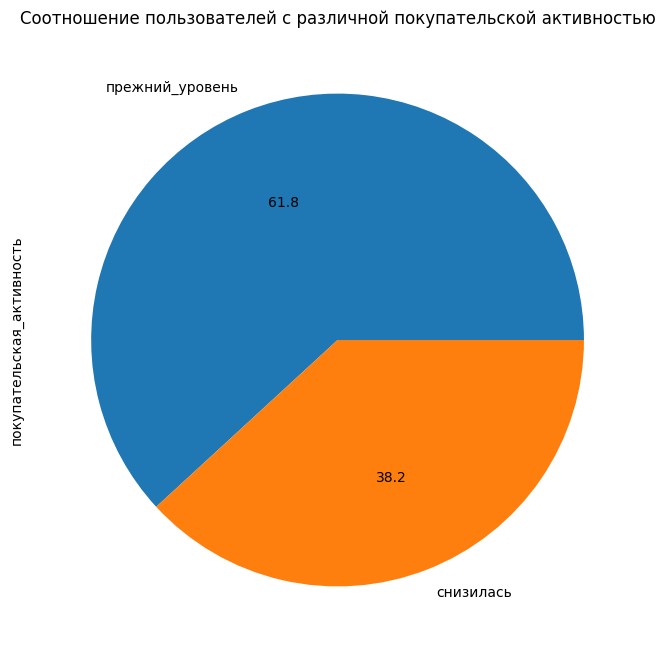

In [161]:
# Определим соотношение пользователей с разным уровнем покупательской способности
df_market_file['покупательская_активность'].value_counts().plot(kind='pie', figsize = (8,8),  autopct='%.1f')
plt.title('Соотношение пользователей с различной покупательской активностью')
plt.show()

<br/>
<div class="alert alert-info">
Наблюдается снижение покупательской активности для 38% пользователей. 
</div>

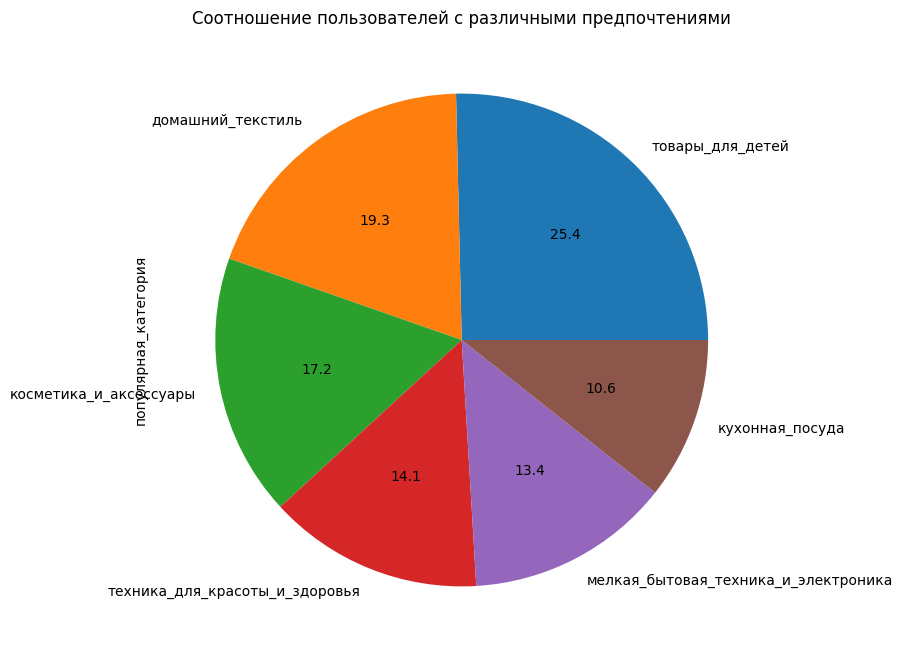

In [162]:
# Определим распределение пользователей по категориям
df_market_file['популярная_категория'].value_counts().plot(kind='pie', figsize = (8,8),  autopct='%.1f')
plt.title('Соотношение пользователей с различными предпочтениями')
plt.show()


Наибольшей популярностью среди пользователей пользуются товары для детей, домашний текстиль и косметика и аксессуары. Рассмотрим распределения категориальных признаков для разных уровней покупательской активности


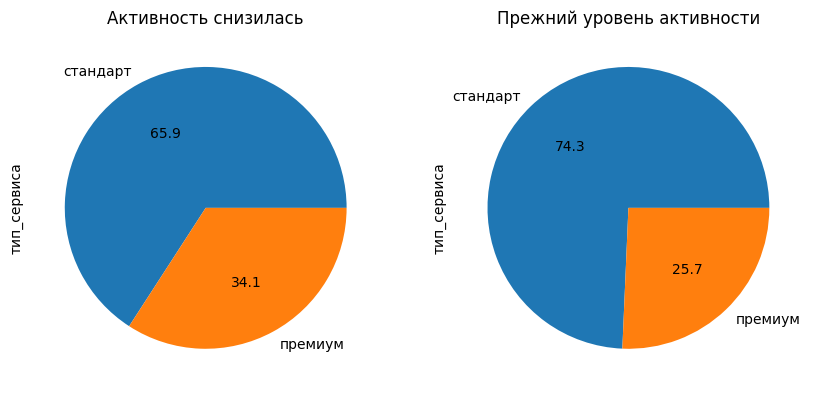

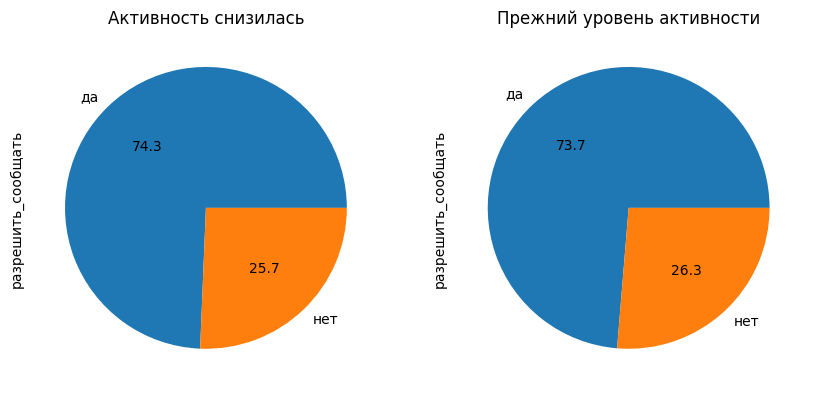

In [163]:
# Построим рядом диаграммы распределений для категориальных признаков при разной покупательской активности
for column in df_market_file.select_dtypes(include=['object']).columns[1:3]:
    
    plt.subplots(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    df_market_file.loc[df_market_file['покупательская_активность'] == 'снизилась', column].value_counts().plot(kind='pie', y= column, autopct='%.1f')
    plt.title('Активность снизилась')

    plt.subplot(1, 2, 2)
    df_market_file.loc[df_market_file['покупательская_активность'] == 'прежний_уровень', column].value_counts().plot(kind='pie', y= column, autopct='%.1f')
    plt.title('Прежний уровень активности')

    #plt.tight_layout(2)
    
    plt.show()


Распределения показывают, что среди пользователей со снизившимся показателем активности доля клиентов, использующий премиум аккаунт больше, чем среди пользователей с прежним уровнем активности. Соотношение пользователей, согласившихся на рассылку примерно одинаковое.


In [164]:
# Посмотрим на распределение в распределении популярных категорий
serv_type = pd.DataFrame()
serv_type['снизилась']= df_market_file.loc[df_market_file['покупательская_активность'] == 'снизилась', 'популярная_категория'].value_counts()
serv_type['прежний_уровень'] = df_market_file.loc[df_market_file['покупательская_активность'] == 'прежний_уровень', 'популярная_категория'].value_counts()
serv_type

,снизилась,прежний_уровень
товары_для_детей,145,184
косметика_и_аксессуары,105,118
домашний_текстиль,101,149
кухонная_посуда,66,72
техника_для_красоты_и_здоровья,51,132
мелкая_бытовая_техника_и_электроника,27,147



Представленная выше таблица наглядно демонстриует, что в категориях товары для детей, косметика, текстиль и посуда существенное число пользователей снизили покупательскую активность. Менее всего пострадали техника для красоты и здоровья и мелкая бытовая техника



Анализ распределения категориальный признаков позволяет отметить следующее:
- покупательская активность примерно 40% пользователей снизилась;
- наибольшей популярностью среди пользователей пользуются товары для детей, домашний текстиль и косметика и аксессуары;
- среди пользователей со снизившимся показателем активности доля клиентов, использующий премиум аккаунт больше, чем среди пользователей с прежним уровнем активности;
- в категориях товары для детей, косметика, текстиль и посуда существенное число пользователей снизили покупательскую активность. Менее всего снизилась активность пользователей в категориях техника для красоты и здоровья и мелкая бытовая техника.


#### Количественные параметры df_market_file

In [165]:
# Выделим столбцы, содержащие числовые значения
num_col = df_market_file.select_dtypes([np.number]).columns

In [166]:
# Изучим распределения числовых значений
for column in num_col:
    print(df_market_file[column].describe(),'\n')

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 

count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.

Приведенная выше общая информация о количественных признаках не позволяет выделить аномальные значения. 


Кроме того, приведенные выше распределения не отражают особенностей распределений числовых признаков для клиентов с разными показателями покупательской активности. Рассмотрим гистограммы распределений численных признаков для двух групп пользователей - со снизившейся и оставшейся на прежнем уровне покупательской активностью. Вертикальными линиями отметим положение медианных значений рассматривамого показателя: синим цветом - для снизившейся активности, красным - для прежнего уровня


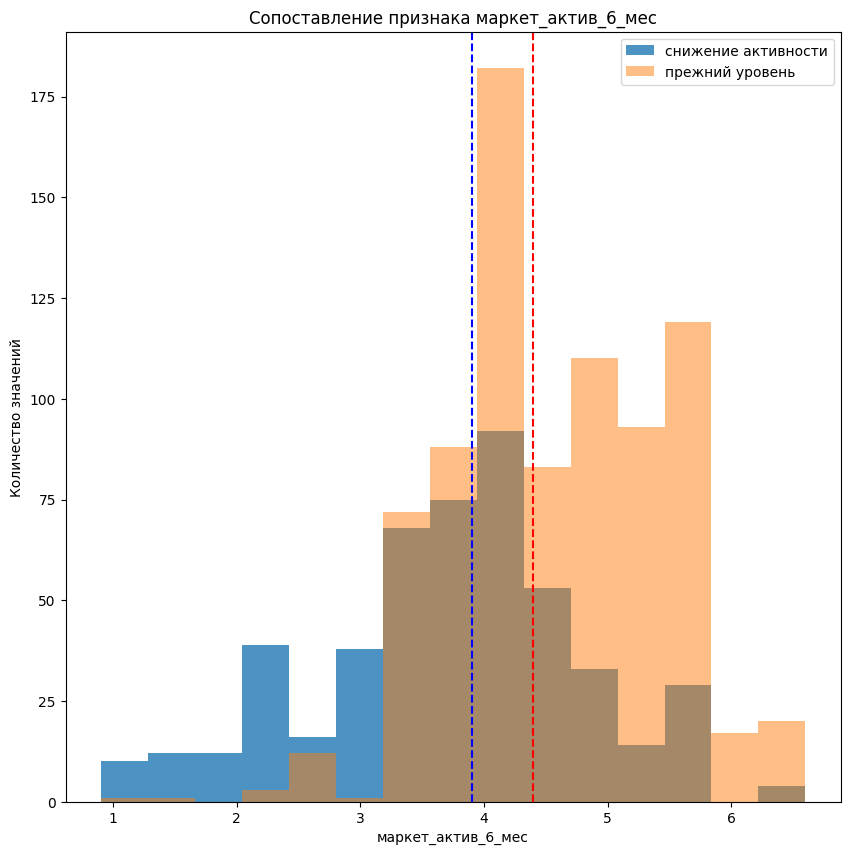

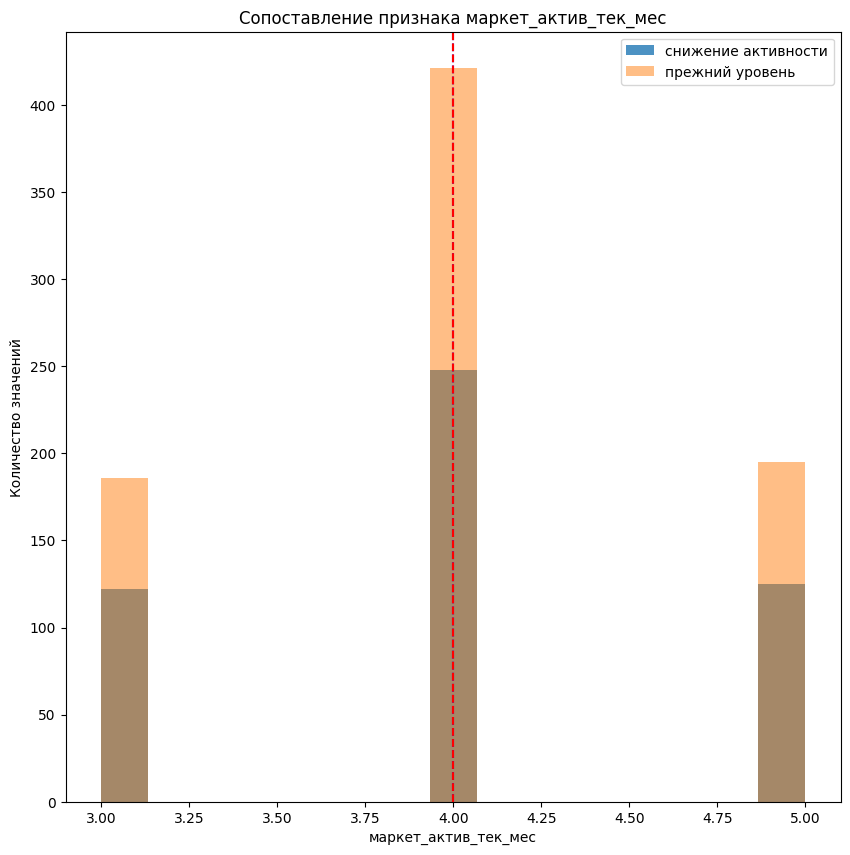

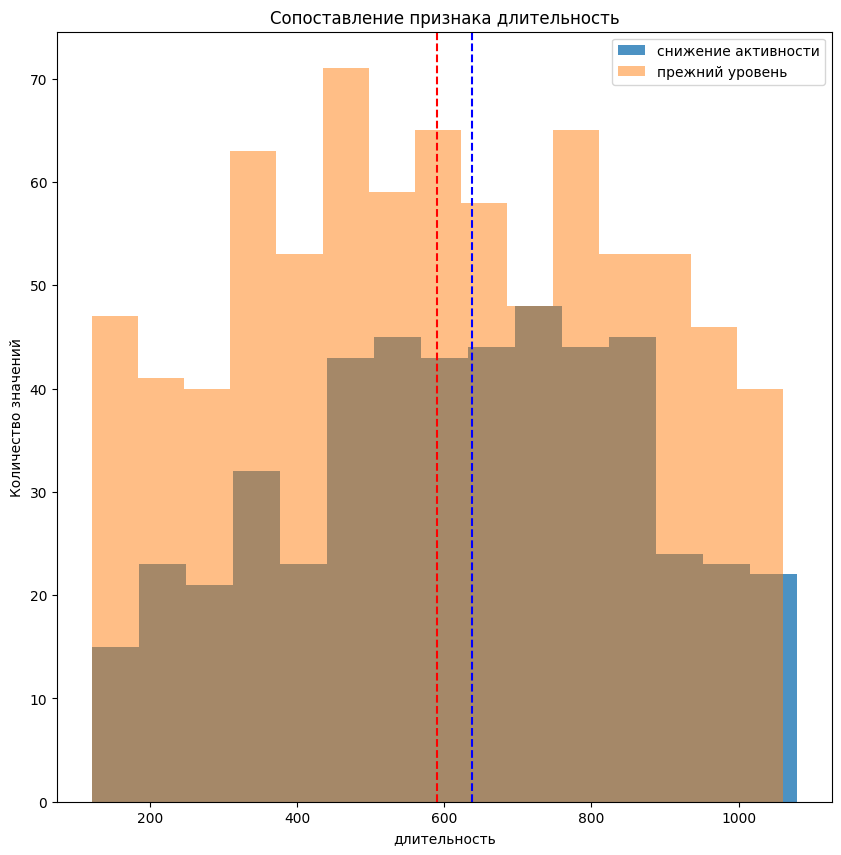

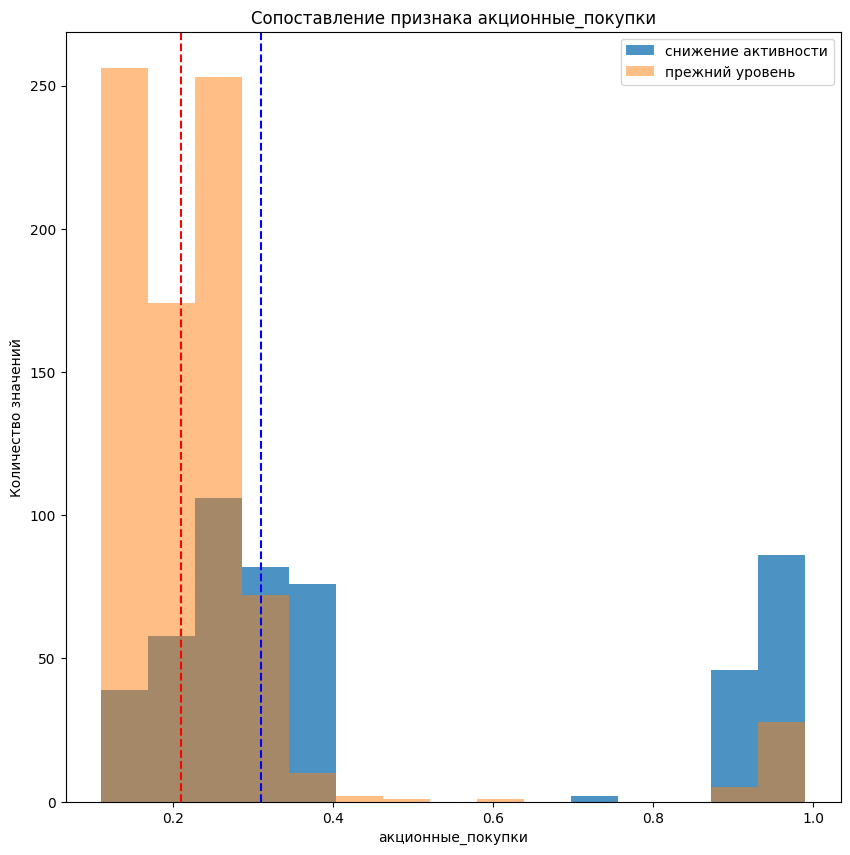

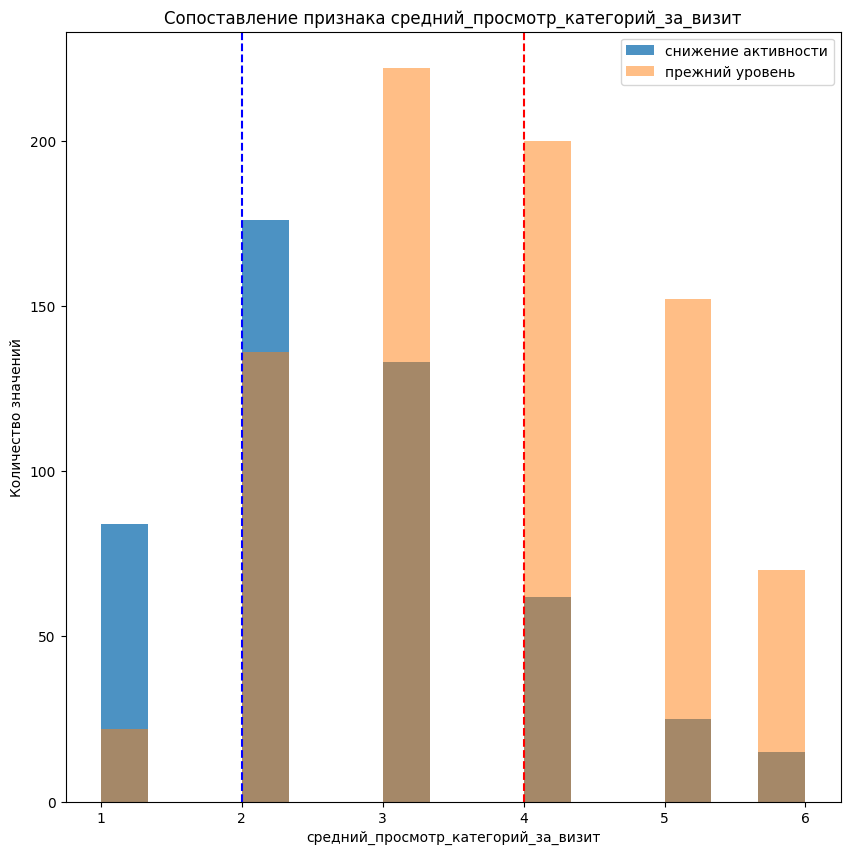

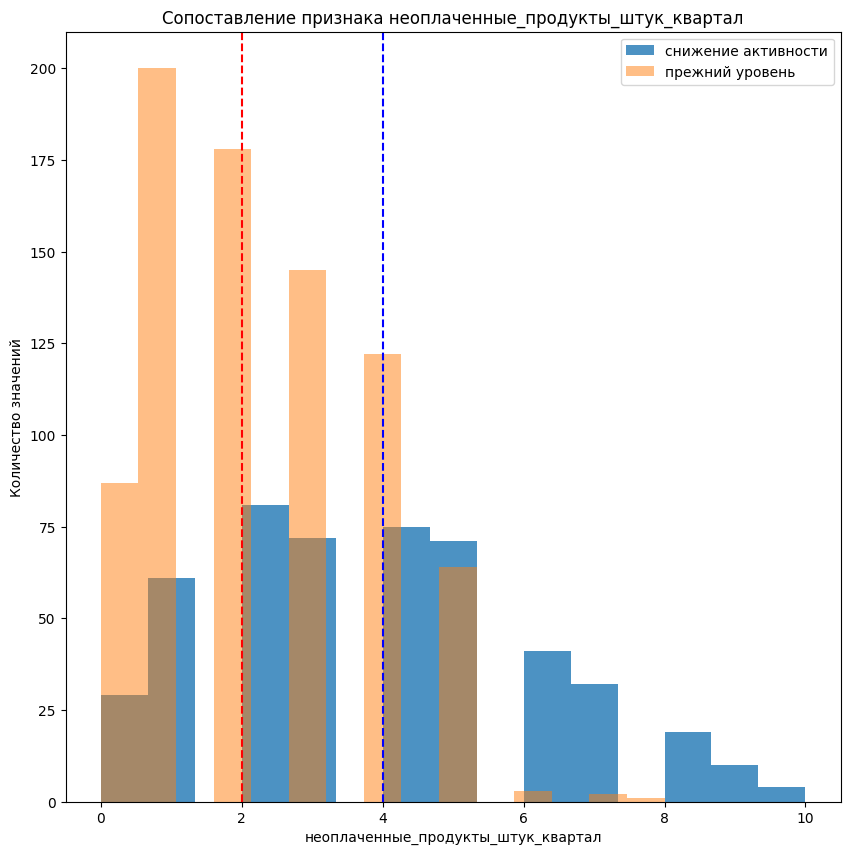

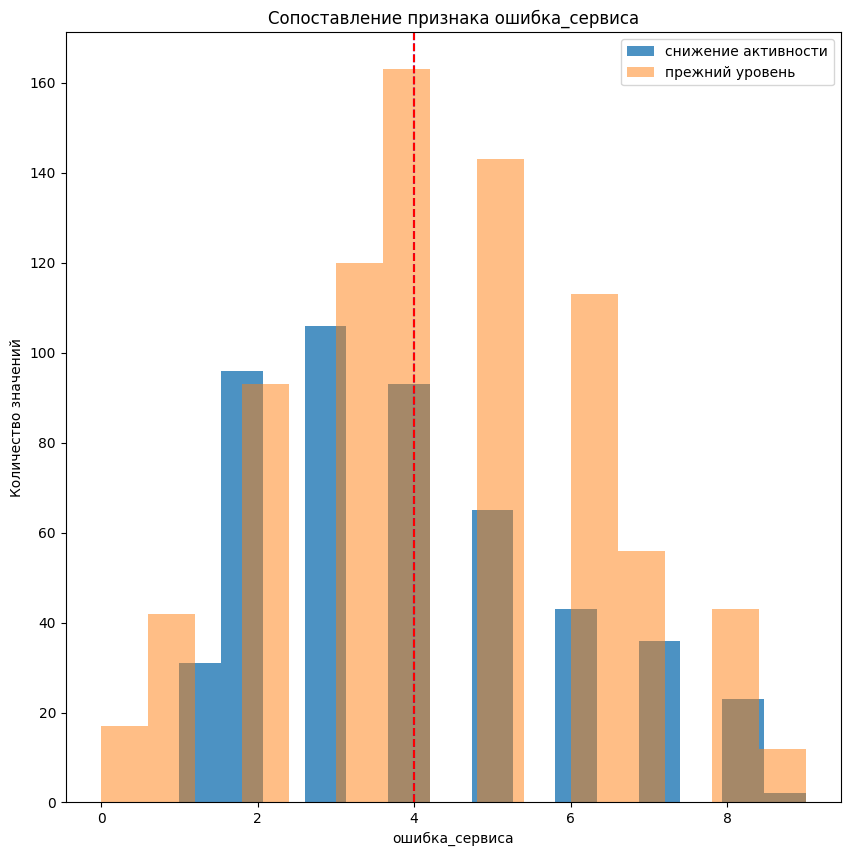

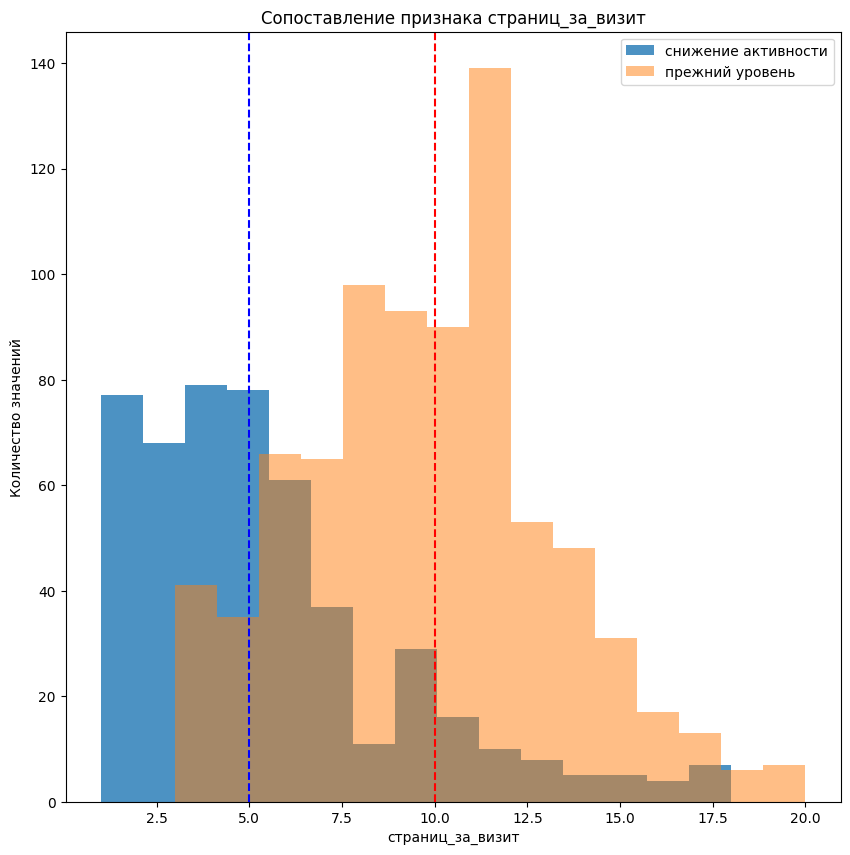

In [167]:
for column in num_col:
    
    plt.figure(figsize=(10, 10))
    plt.hist(df_market_file.loc[df_market_file['покупательская_активность'] == 'снизилась', column], bins=15, alpha=0.8, label='снижение активности')
    plt.hist(df_market_file.loc[df_market_file['покупательская_активность'] == 'прежний_уровень', column], bins=15, alpha=0.5, label='прежний уровень')
    
    # Рисуем вертикальные линии, отвечающие за медианные значения
    x1 = df_market_file.loc[df_market_file['покупательская_активность'] == 'снизилась', column].median()
    x2 = df_market_file.loc[df_market_file['покупательская_активность'] == 'прежний_уровень', column].median()
    plt.axvline(x=x1, color='b', linestyle='--')
    plt.axvline(x=x2, color='r', linestyle='--')
    
    plt.title(f'Сопоставление признака {column}')
    plt.xlabel(column)
    plt.ylabel('Количество значений')

    plt.legend()
    
    
plt.show()



Приведенные выше гистограммы распределения числовых признаков в датафрейме в общем виде позволяют сделать следующие наблюдения: для большинства величин форма распределений близка к нормальному виду, однако можно выделить явное отличие от нормального распределения для признака "Акционные_покупки" (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев). Подобное распределение позволяет выделить две категории пользователей - совершающих покупки преимущественно акционных товаров и нет. Также можно отметить малое количество уникальных значений для количества маркетинговых коммуникаций в текущем месяце - от трех до пяти

Если рассматривать распределения с точки зрения целевого признака - уровня покупательской активности - то можно отметить следующее:
- Показатель маркетинговой активности за последние 6 месяцев для пользователей со снизившейся покупательской активностью меньше, чем для полльзователей с прежним уровнем активности. Это значит, что рекламные предложения, рассылки помогают сохранить покупательский интерес.
- Длительность(время, прошедшее с момента регистрации на сайте) для покупателей с разными уровнями активности незначительно различается - к снижению активности более предрасположены клиенты, давно зарегестрированные на сайте.
- Признак, отвечающий за долю акционных покупок носит скорее дискретный характер распределения и позволяет выделить две группы пользователей - совершающих преимущественно акционные покупки и не пользующихся акциями. При этом снижение уровня покупательской активности наиболее часто наблюдается именно для покупателей, предпочитающий акционные покупки.
- Значения среднего числа просмотра категорий за визит довольно сильно различаются для пользователей с разной активностью - для снизившейся активности характерно и снижение числа просматриваемых категорий.
- Число неоплаченных продуктов за квартал растет при низкой покупательской активности.
- Средние значения ошибок сервиса для покупателей с разными уровнями активности совпадают, однако максимумы распределений этого признака несколько различаются. Причина в различии может быть связана с разным временем взаимодействия клиентов с сайтом - для покупателей с прежним уровнем активности выше значение времени, которое они тратят на изучение сайта и больше число просматриваемых страниц, а значит - выше вероятность возникновения ошибки сервиса.
- Пользователи со снизившейся покупательской активностью просматривают значительно меньше страниц на сайте.


### Данные о выручке, получаемой магазином с покупателя (df_market_money)

In [168]:
# Изучим распределения числовых значений
for column in df_market_money.columns:
    print(df_market_money[column].describe(),'\n')

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: выручка_предыдущий_месяц, dtype: float64 

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: выручка_препредыдущий_месяц, dtype: float64 

count      1297.000000
mean       5316.449268
std        2942.469139
min        2758.700000
25%        4706.600000
50%        5180.300000
75%        5761.300000
max      106862.200000
Name: выручка_текущий_месяц, dtype: float64 



Распределения в датафрейме показывает наличие аномально высоких значений в параметре "выручка_текущий_месяц"

In [169]:
# Выведем аномально высокое значение выручки в текущем месяце
df_market_money.loc[df_market_money['выручка_текущий_месяц']>20000]

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215380,6077.0,5051.0,106862.2


Аномальное значение всего одно и может быть связано как с большим объемом покупок конкретного клиента в текущем месяце, так и с ошибкой в данных. 

Поскольку подобных аномально высоких выручки более не зафиксировано, на этапе создания объединенного датафрейма предлагается удалить данные, связанные с этим id, чтобы избежать ошибок в прогнозировании.

Построим гистограммы распределений величин без учета аномального значения.

In [170]:
# Удалим данные аномального пользователя из имеющихся в нашем распоряжении датафреймов
for df in ['df_market_file', 'df_market_money', 'df_market_time','df_money']:
    locals()[df] = locals()[df].drop(index=215380)
    print(f'итоговая длина файла {df} : {len(locals()[df])}')

итоговая длина файла df_market_file : 1296
итоговая длина файла df_market_money : 1296
итоговая длина файла df_market_time : 1296
итоговая длина файла df_money : 1296


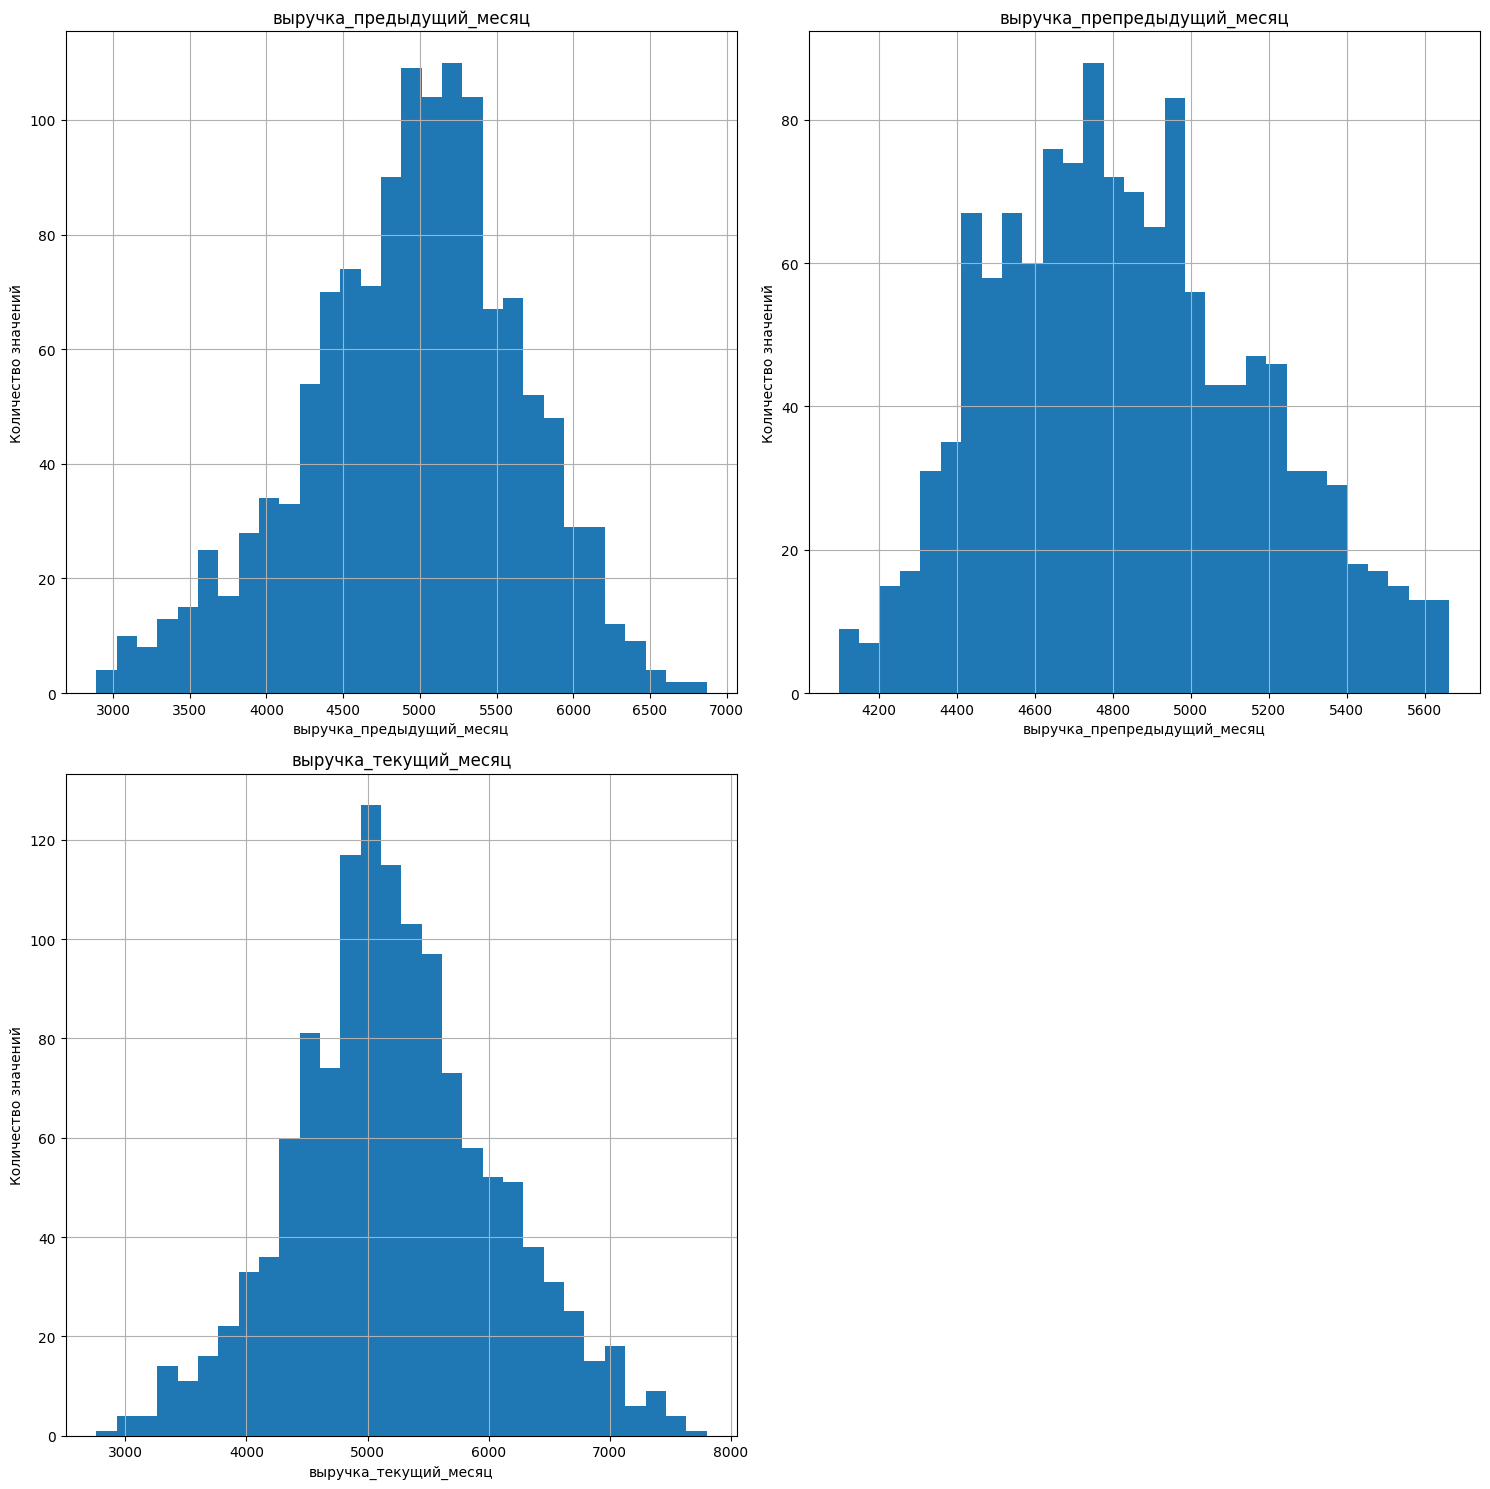

In [171]:
# Посмотрим на распределение величин в столбцах, содержащих численные значения
axes = df_market_money.hist(df_market_money.columns, bins = 30, figsize=(15, 15))
titles = df_market_money.columns
xlabel = df_market_money.columns
#ylabel = num_col[1:]

for i, ax in enumerate(axes.flatten()):
    if i<3:
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel[i])
        ax.set_ylabel('Количество значений')
plt.tight_layout() #дополнительная проверка на случай, если надо строить три графика, без нее будет ошибка
plt.show()

Распределение значений выручки очень близко к нормальному виду.

###  Данные о времени, которое покупатель провёл на сайте (df_market_time)


In [172]:
# Изучим распределения числовых значений
for column in df_market_time.columns:
    print(df_market_time[column].describe(),'\n')

count    1296.000000
mean       13.470679
std         3.937630
min         5.000000
25%        10.750000
50%        13.000000
75%        17.000000
max        23.000000
Name: время_предыдущий_месяц, dtype: float64 

count    1296.000000
mean       13.210648
std         4.221794
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: время_текущий_месяц, dtype: float64 



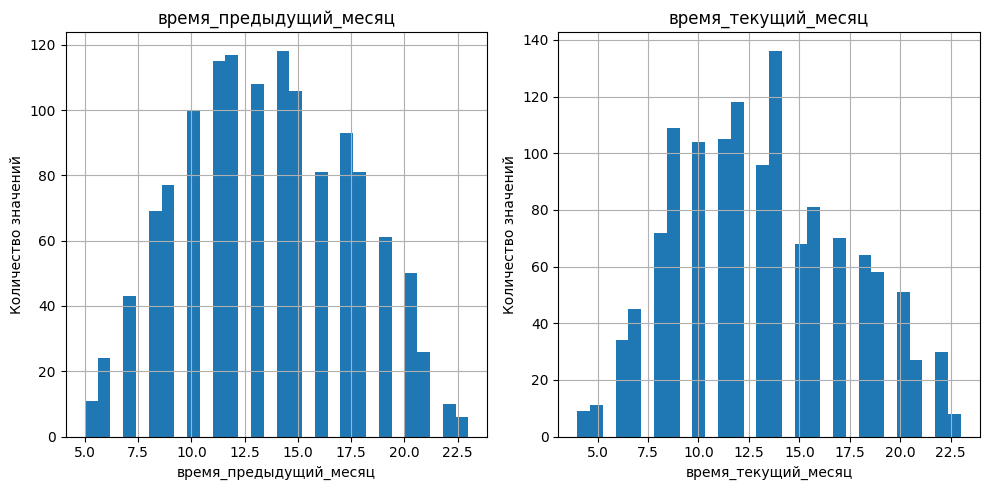

In [173]:
# Посмотрим на распределение величин в столбцах, содержащих численные значения
axes = df_market_time.hist(df_market_time.columns, bins = 30, figsize=(10, 5))
titles = df_market_time.columns
xlabel = df_market_time.columns
#ylabel = num_col[1:]

for i, ax in enumerate(axes.flatten()):
    if i<3:
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel[i])
        ax.set_ylabel('Количество значений')
plt.tight_layout() #дополнительная проверка на случай, если надо строить три графика, без нее будет ошибка
plt.show()

Форма распределения времени, которое пользователи тратят на изучение сайта близко к нормальному виду со средним значением около 13 минут.

###  Данные о среднемесячной прибыли покупателя за последние 3 месяца (df_money)

In [174]:
df_money['прибыль'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

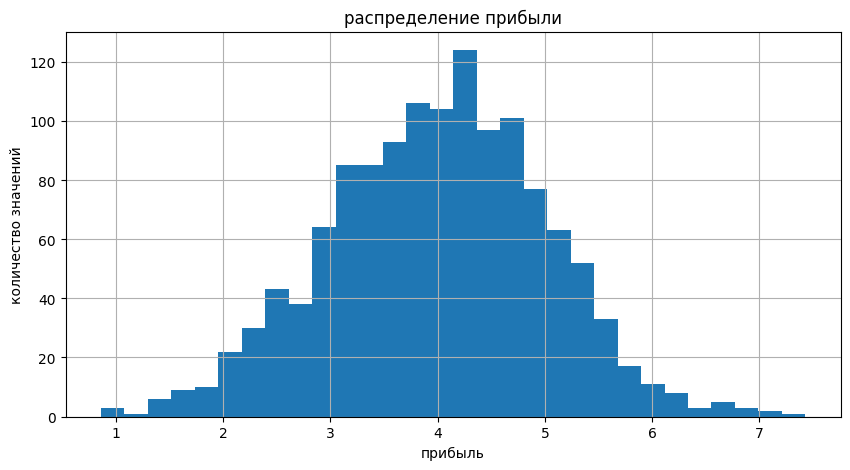

In [175]:
df_money['прибыль'].hist(bins = 30, figsize=(10, 5))

plt.title('распределение прибыли')
plt.xlabel('прибыль')
plt.ylabel('количество значений')
plt.show()

Распределение величины прибыли за последние три месяца носит нормальный вид со средним значением в районе 4.

### Заключение по исследовательскому анализу данных


В процессе исследовательского анализа данных рассматривались пользователи, совершавшие покупки в течение трех предыдущих месяцев. 


Анализ распределений параметров, содержащих данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (df_market_file), показали следующее:

Распределения категориальных параметров представлены следующим образом:
- покупательская активность примерно 40% пользователей снизилась;
- наибольшей популярностью среди пользователей пользуются товары для детей, домашний текстиль и косметика и аксессуары;
- среди пользователей со снизившимся показателем активности доля клиентов, использующий премиум аккаунт больше, чем среди пользователей с прежним уровнем активности;
- в категориях товары для детей, косметика, текстиль и посуда существенное число пользователей снизили покупательскую активность. Менее всего снизилась активность пользователей в категориях техника для красоты и здоровья и мелкая бытовая техника.


Для большинства величин форма распределений близка к нормальному виду, однако можно выделить явное отличие от нормального распределения для признака "Акционные_покупки", распределение которого позволяет выделить две категории пользователей - совершающих покупки преимущественно акционных товаров и нет.

Если рассматривать распределения в рамках значений покупательской активности, то можно выделить следующие аспекты:
- Для клиентов со снизившейся активностью характерен более низкий показатель маркетинговой активности за последние 6 месяцев. Возможно, для поддержания интереса пользователей необходимо увеличивать число коммуникаций с ними.
- К снижению активности более предрасположены клиенты, давно зарегестрированные на сайте.
- Снижение уровня покупательской активности наиболее часто наблюдается именно для покупателей, предпочитающий акционные покупки.
- Для снизившейся активности характерно и снижение числа просматриваемых категорий товаров.
- Число неоплаченных продуктов за квартал растет при низкой покупательской активности.
- Средние значения ошибок сервиса для покупателей с разными уровнями активности совпадают, нет оснований подозревать существенное влияние данного параметра на покупательскую активность.
- Пользователи со снизившейся покупательской активностью просматривают значительно меньше страниц на сайте.

Анализ данных из остальных датафреймов позвоялет сделать следующие наблюдения:

- Анализ данных о выручке (df_market_money) выявил аномальнно высокое значение выручки за последний месяц для одного из клиентов. Данное значение предлагается исключить из анализа как аномальное. В остальном форма распределений выручки носит нормальный характер со средним значением в райное 5000.
- Анализ данных о времени (df_market_time) показал, что форма распределения времени, которое пользователи тратят на изучение сайта близко к нормальному виду со средним значением около 13 минут.
- Данные о среднемесячной прибыли (df_money) за последние три месяца имеют нормальное распределение со средним значением в районе 4.





## Объединение таблиц

Объедините таблицы market_file.csv, market_money.csv, market_time.csv

### Объединение таблиц market_file.csv, market_money.csv, market_time.csv

In [176]:
df_united = df_market_file
df_united = df_united.merge(df_market_money, left_index=True,right_index=True, how='left')
df_united = df_united.merge(df_market_time, left_index=True,right_index=True, how='left')

estimated_shape = df_market_file.shape[1] + df_market_money.shape[1] + df_market_time.shape[1]

print(f'Расчетное число столбцов: {estimated_shape}, Полученное число столбцов: {df_united.shape[1]}')
print(f'Расчетная длина: {len(df_market_file)}, Полученная длина: {df_united.shape[0]}')

Расчетное число столбцов: 17, Полученное число столбцов: 17
Расчетная длина: 1296, Полученная длина: 1296


In [177]:
df_united.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Размерность итогового датафрейма после объединения соответствует ожидаемой, считаем, что объединение прошло успешно.

### Заключение по объединению таблиц

Для удобства дальнейшей работы были объеденены таблицы df_market_file, df_market_money и df_market_time. Проверка размерности итогового объединенного датафрейма показала корректность проведенного объединения. Из итогового датафрейма удалена строка, отвечающая за данные пользователя, для которого было выявлено аномальное значение выручки на этапе исследовательского анализа данных.

##  Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

### Построение матрицы с коэффициентами корреляции

In [178]:
df_united.select_dtypes([np.number]).columns

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'время_предыдущий_месяц', 'время_текущий_месяц'],
      dtype='object')

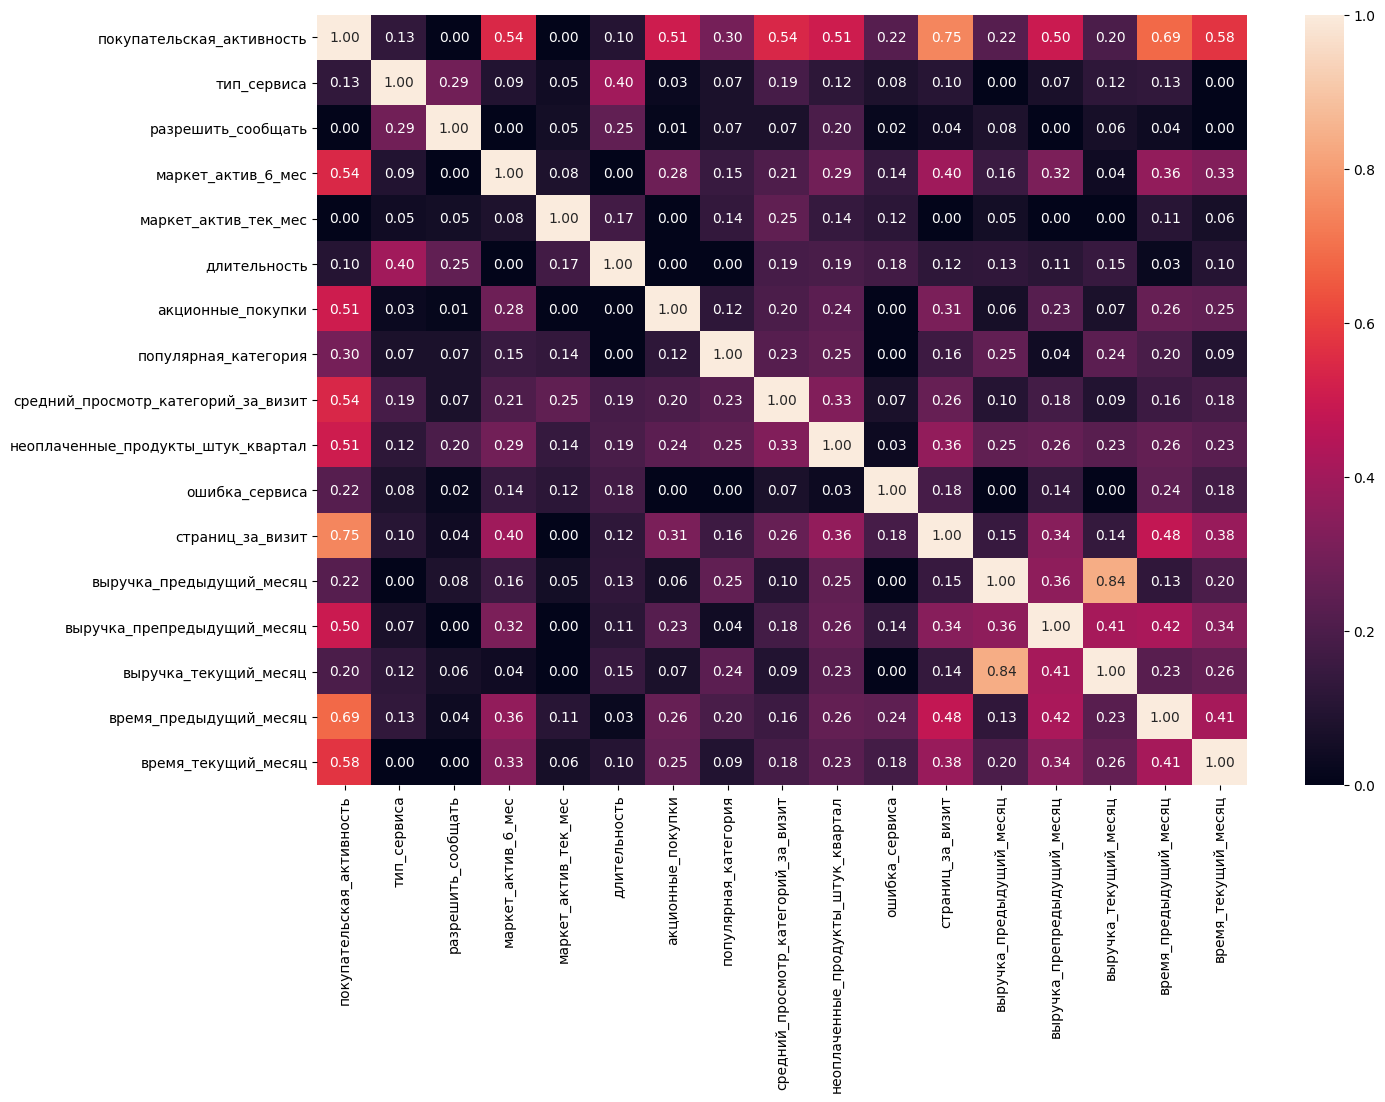

In [179]:
plt.figure(figsize=(15,10))
sns.heatmap(df_united.phik_matrix(interval_cols=df_united.select_dtypes([np.number]).columns) , annot=True, fmt='.2f')#cmap='cividis')
plt.show()

Приведенная выше матрица корреляций позволяет отметить отсутвие признаков с высокими коэффициентами корреляции (около 0.9), чтобы подозревать мультиколлиниарность. 

Определим признаки, имеющие наибольшее значение коэффициента корреляции с покупательской активностью:

In [180]:
matrix = df_united.phik_matrix()
matrix.loc[matrix['покупательская_активность'] > 0.5]['покупательская_активность'].sort_values(ascending=False)[1:]

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц']


страниц_за_визит                       0.749888
время_предыдущий_месяц                 0.685138
время_текущий_месяц                    0.576770
маркет_актив_6_мес                     0.544831
средний_просмотр_категорий_за_визит    0.539607
акционные_покупки                      0.506276
неоплаченные_продукты_штук_квартал     0.505655
Name: покупательская_активность, dtype: float64

Также можно отметить довольно высокие коэффициенты корреляции для следующих параметров:
- время_предыдущий_месяц и страниц_за визит (0.48);
- время_предыдущий_месяц и выручка_препредыдущий месяц (0.42);
- время_текущий_месяц и время_предыдущий_месяц (0.41);
- длительность и тип_сервиса (0.4)

### Заключение по корреляционному анализу

Для проведения корреляционного анализа была построена матрица коэффициентов корреляций для категориальных и количественных параметров сводной таблицы df_united, полученной в результате объединения данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (df_market_file), данных о выручке, получаемой магазином с покупателя (df_market_money) и данных о времени (в минутах), которое покупатель провёл на сайте в течение периода (df_market_time).

Анализ полученной матрицы позволил отметить отстутствие признаков мультиколлинеарности между элементами: наибольшее значение коэффициента корреляции составляет 0.75.

Также были выделены признаки с наиболее заметными коэффициентами корреляции. Так, для признака 'покупательская_активность' можно выделить следующие значения коэффициентов корреляции:
- страниц_за_визит (0.75)
- время_предыдущий_месяц (0.67)
- время_текущий_месяц (0.58)
- маркет_актив_6_мес (0.55)

Среди остальных признаков, можно выделить следующие взаимосвязи:
- выручка за текущий и предыдущий месяц (0.84)
- время_предыдущий_месяц и страниц_за визит (0.48);
- время_предыдущий_месяц и выручка_препредыдущий месяц (0.42);
- время_предыдущий_меся и время_текущий_месяц (0.41);
- длительность и тип_сервиса (0.4)

## Использование пайплайнов

### Подготовка данных

В объединенном датафрейме выделим количественные и категориальные признаки, запишем их в отдельные переменные. Для подготовки данных будет использован ColumnTransformer. Количественные и категориальные признаки будут обработаны в пайплайне отдельно. Для кодирования категориальных признаков использются минимум два кодировщика, для масштабирования количественных — минимум два скейлера. Для каждой модели данные будут подготовлены с разным кодированием и масштабированием.

In [181]:
# Зададим значения параметров для кодирования данных и разбиения на выборки
RANDOM_STATE=42
TEST_SIZE = 0.4

# Разобъем датафрейм на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_united.drop(['покупательская_активность'], axis=1),
    df_united['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_united['покупательская_активность'])

# Закодируем целевую переменную
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test) 

In [182]:
# Проверим, как закодированы значения целевой переменной
print(label_encoder.inverse_transform([0, 1])) 

['прежний_уровень' 'снизилась']


In [183]:
# Категориальные признаки для OHE-кодирования 
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
# Категориальные признаки для ORD-кодирования
ord_columns = ['тип_сервиса'] 

# Создадим список количественных признаков
num_columns = list(X_train.select_dtypes([np.number]).columns)
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'время_предыдущий_месяц',
 'время_текущий_месяц']

In [184]:
# Создадим пайплайн для OHE-кодирования категориальных признаков 
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [185]:
# Создадим пайплайн для ORD-кодирования категориальных признаков
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт','премиум'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [186]:
# Создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

In [187]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Обучение моделей

Обучим четыре модели: DecisionTreeClassifier(), LogisticRegression() и  SVC().

Цель модели - предсказание активности пользователя(снизится или останется на прежнем уровне), то есть решение задачи классификации.

В нашем случае необходимо разработать модель, наиболее качественно предсказывающую покупателькую активность пользователей. Учитывая возможный дисбаланс целевого признака, для выбора лучшей модели предлагается использовать метрику ROC-AUC.

In [209]:
# создадим 4 модели с различными параметрами
param_grid = [

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(4,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]

In [210]:
# Выберем наиболее удачную модель
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   Simp...
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'время_предыдущий_месяц',
                                                   'время_текущий_месяц'])])),
                ('models',
                 LogisticRegression(C=4, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [211]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

In [212]:
# Выведем параметры моделей
result = pd.DataFrame(randomized_search.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

   rank_test_score                                       param_models  \
0                1  LogisticRegression(C=4, penalty='l1', random_s...   
4                2  LogisticRegression(C=4, penalty='l1', random_s...   
5                3  LogisticRegression(C=4, penalty='l1', random_s...   
1                4  LogisticRegression(C=4, penalty='l1', random_s...   
6                5  LogisticRegression(C=4, penalty='l1', random_s...   
7                6  LogisticRegression(C=4, penalty='l1', random_s...   
8                7  LogisticRegression(C=4, penalty='l1', random_s...   
2                8  LogisticRegression(C=4, penalty='l1', random_s...   
3                9  LogisticRegression(C=4, penalty='l1', random_s...   
9               10  LogisticRegression(C=4, penalty='l1', random_s...   

   mean_test_score                                             params  
0         0.894523  {'preprocessor__num': StandardScaler(), 'model...  
4         0.894417  {'preprocessor__num': StandardSc

In [213]:
# Посчитаем метрику roc-auc на тестовой выборке
y_pred = randomized_search.best_estimator_.predict_proba(X_test)
y_pred_one = y_pred[:,1]
print (f'Площадь ROC-кривой:{roc_auc_score(y_test,y_pred_one):.2f}', )

Площадь ROC-кривой:0.91


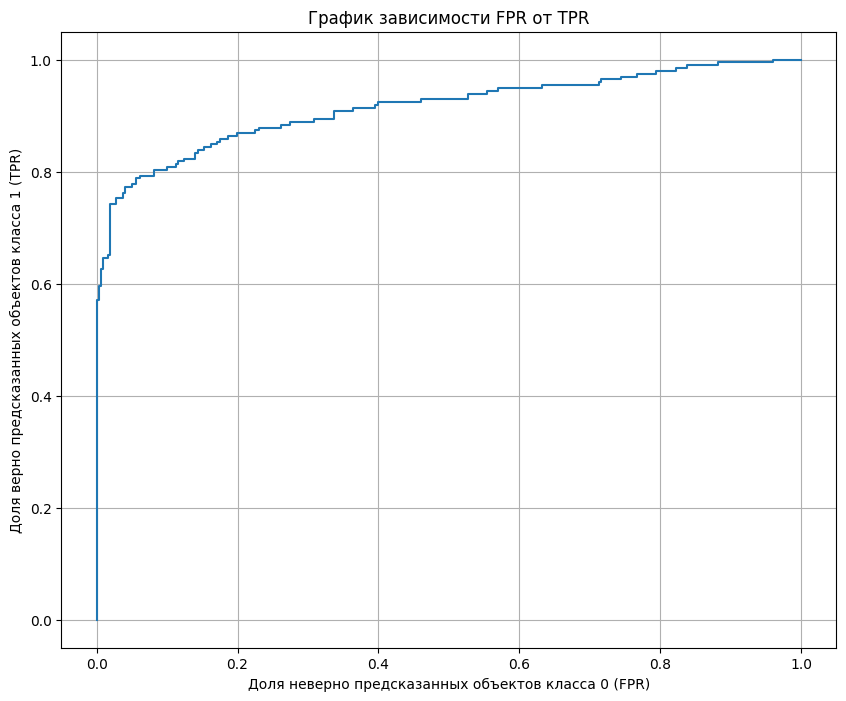

In [214]:
# рассчитаем значения FPR и TRP
fpr, tpr, threshold = roc_curve(y_test, y_pred_one, pos_label=1)
# построим график зависимости FPR от TPR
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('Доля неверно предсказанных объектов класса 0 (FPR)')
plt.ylabel('Доля верно предсказанных объектов класса 1 (TPR)')
plt.grid(visible=True, which='major', axis='both')
plt.show()


    
В результате наиболее качественный результат показала модель логистической регрессии. Для выбранной модели на тестовой выборке данных было рассчитано значение метрики roc-auc, составившее 0.91 и построена кривая зависимости доли верно предсказанных объектов класса 1 (TPR) от доли неверно предсказанных объектов класса 0(FPR).


### Заключение по использованию пайплайнов

Целью создания модели машинного обучения было наиболее точное предсказание уровня активности пользователя.
Таким образом, решалась задача классификации, при которой лучшей считалась бы модель наилучшей точностью предсказаний. С учетом возможного дисбаланса целевого признака в качестве метрики была выбрана ROC-AUC.

С целью определения наиболее качественной модели машинного обучения был разработан пайплайн, включающий в себя этапы кодирования категориальных признаков, масштабирования числовых признаков, подготовки данных и обучения различных моделей машинного обучения.

Для кодирования категориальных признаков исполось OHE и ORD кодирование:
- OHE-кодирование применялось к признакам "разрешить_сообщать" и "популярная_категория", поскольку в них не предусмотрено ранжирование.
- ORD-кодирование применялось к признаку "тип_сервиса", для которого ранжирование устроено в следующем порядке: 'стандарт' ,'премиум'.

Масштабирование количественных признаков осуществлялось с помощью инструментов StandardScaler() и MinMaxScaler(), использующихся в качестве гиперпарметров для каждой модели.

В качестве моделей машинного обучения использовались:
- DecisionTreeClassifier с гиперпараметрами max_depth (количество уровней с правилами) в диапазоне от 2 до 5 и max_features (максимальное число признаков) в диапазоне от 2 до 17
- KNeighborsClassifier с гиперпараметром n_neighbors (число соседей) в диапазоне от 2 до 10
- LogisticRegression с L1-регуляризацией и значениями гиперпараметра C в диапазоне от 1 до 6
- SVC с гиперпараметрами StandardScaler() и MinMaxScaler().


По результатам работы наиболее качественный результат показала модель логистической регрессии с показателем метрики на тренировочной выборке 0.89 и 0.91 на тестовой.

## Анализ важности признаков

### Оценка важности признаков для лучшей модели

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

In [215]:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

In [216]:
# Масштабирование признаков с использованием скейлера лучшей модели
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'],\
                                 X_train_transformed,\
                                 feature_names = feature_names)

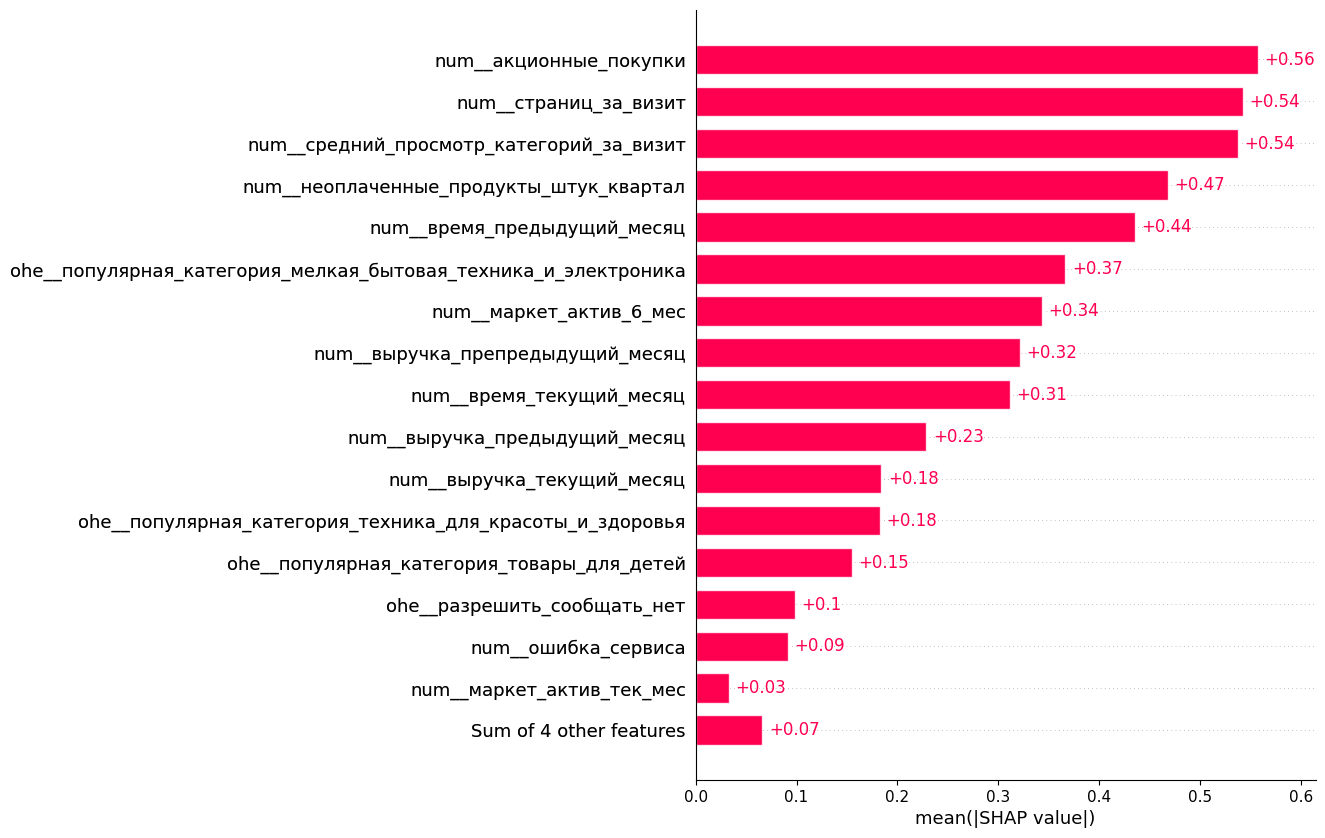

In [217]:
# построим график общей значимости признаков
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=17) 

Полученный график общей значимости признаков показывает, что наибольшее влияние на покупательскую активность оказывают акционные предложения, количество страниц и категорий, простматриваемых за визит, а также число неоплаченных товаров в корзине.

Наименьшее влияние на активность имеет число рассылок в текущем месяце, ошибка сервиса и отказ от дополнительных предложений о товаре.

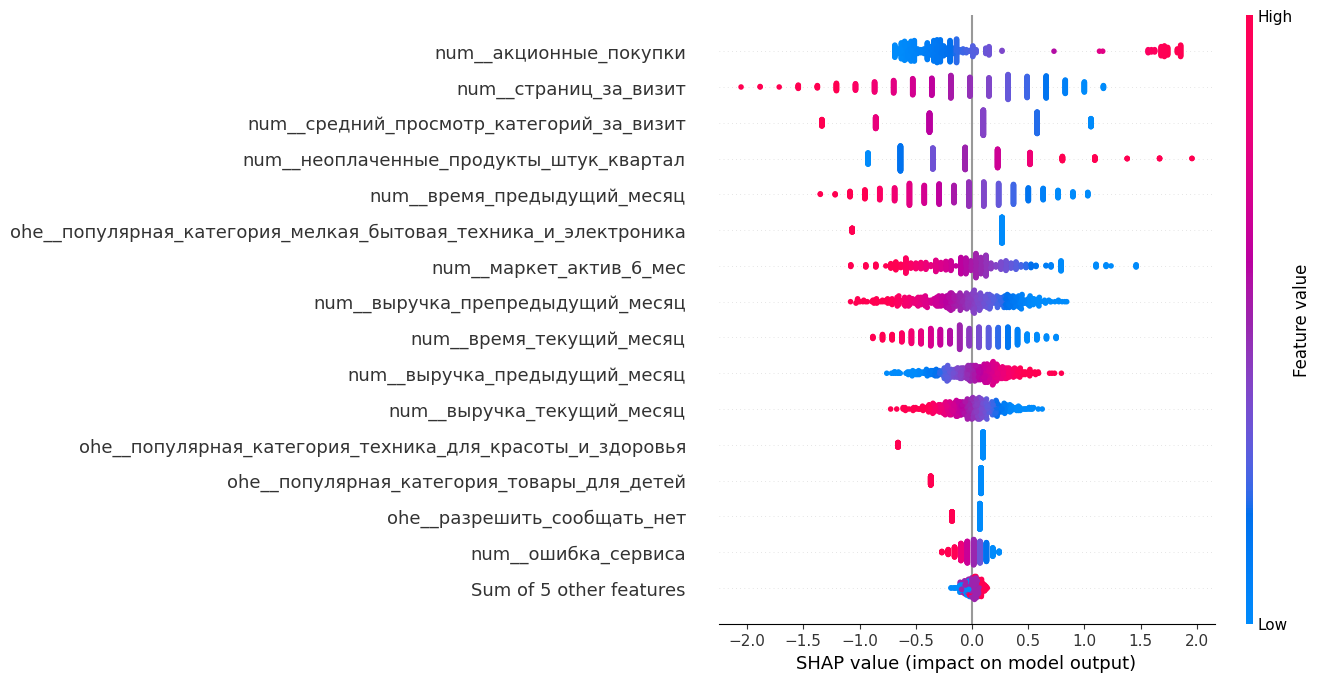

In [218]:
# Изучим влияние каждого признака на пердсказания модели
shap.plots.beeswarm(shap_values, max_display=16)

Низкое значение доли акционных покупок увеличивает вероятность снижения покупательской активности.
Также чем больше страниц за визит изучает пользователь и чем больше категорий он смотрит, тем меньше вероятность снижения покупательской активности.

### Заключение по анализу важности признаков

Для оценки значимости признаков использовался анализ SHAP-значений, который показал, наибольшее влияние на покупательскую активность оказывают акционные предложения, количество страниц и категорий, простматриваемых за визит, а также число неоплаченных товаров в корзине. Наименьшее влияние на активность имеет число рассылок в текущем месяце, ошибка сервиса и отказ от дополнительных предложений о товаре.


Низкое значение доли акционных покупок увеличивает вероятность снижения покупательской активности.
Также чем больше страниц за визит изучает пользователь и чем больше категорий он смотрит, тем меньше вероятность снижения покупательской активности.

## Сегментация покупателей

### Разделение пользователей на группы

Выделим сегмент покупателей, проанализируем его и предложим, как увеличить его покупательскую активность.

#### Создание общего датафрейма, учитывающего прибыль с каждого покупателя

In [219]:
# Для сегментации пользователей создадим отдельный датафрейм
df_segment = X_test
df_segment['вероятность_снижения'] = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

# Добавим в датафрейм значения выручки
df_segment = df_segment.merge(df_money,left_index=True,right_index=True, how='left')

# Проверим, успешно ли прошло объединение
print (f'Потеряно строк при объединении: {len(df_segment) - len(X_test)}')

Потеряно строк при объединении: 0


В датафрейм с тестовой выборкой были добавлены столбцы, содержащие значения прибыли, которую принесли покупатели и значения вероятности снижения покупательской активности/

#### Выделение пользователей с высоким показателем прибыли

Посмотрим, как распределены значения прибыли и вероятность снижения покупательской активности

In [220]:
# Посмотрим, как распределены значения прибыли 
df_segment['прибыль'].describe()

count    519.000000
mean       3.992775
std        0.977723
min        0.860000
25%        3.305000
50%        4.080000
75%        4.655000
max        6.880000
Name: прибыль, dtype: float64

Среднее значение прибыли пользователей - около 4, стандартное отклонение - 0.98. Используем данные параметры для выделения пользователей с высоким уровнем прибыли:

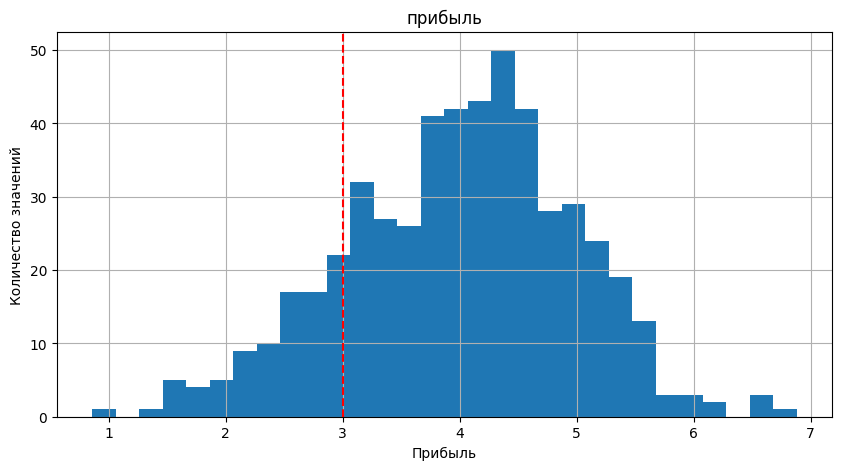

In [221]:
df_segment['прибыль'].hist(bins = 30, figsize=(10,5))
plt.axvline(x=3, color='r', linestyle='--')
plt.title('прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Количество значений')
plt.show()

Справа от вертикальной красной линии находятся пользователи, приносящие наибольшее количество прибыли, и, соответственно, наиболее интересные для сохранения покупательской активности.

Посмотрим, как связаны прибыль и вероятность снижения активности пользователей:

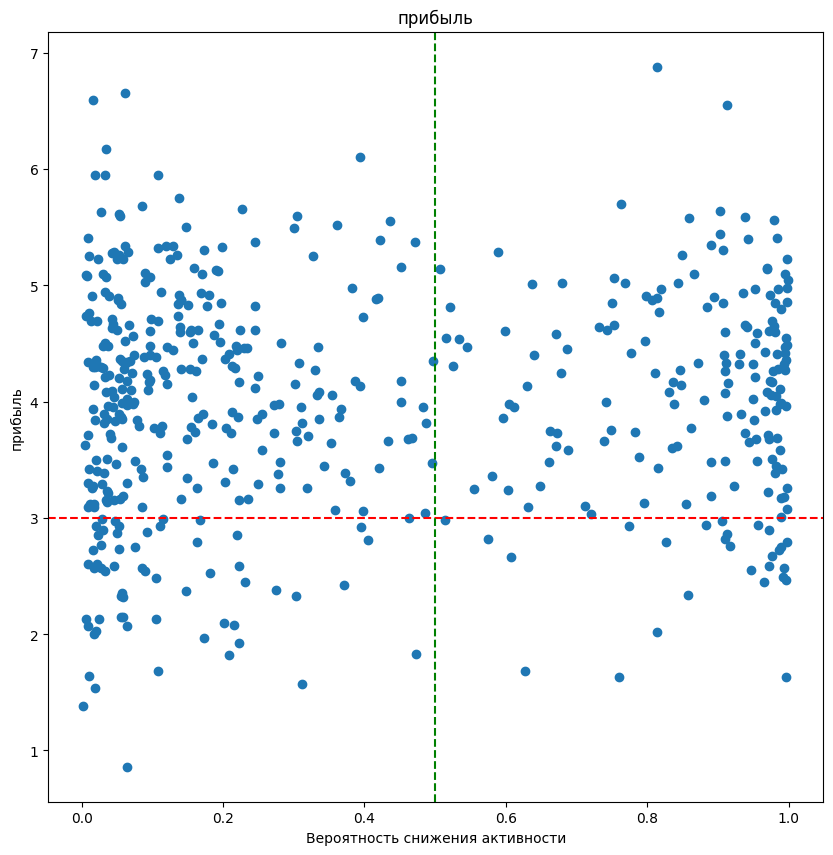

In [222]:
# Построим диаграммы рассеяния
plt.figure(figsize=(10, 10))
plt.scatter(df_segment['вероятность_снижения'], df_segment['прибыль'])

# Добавляем заголовок и метки
plt.title('прибыль')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('прибыль')
    
# Рисуем горизонтальные линии
# Вертикальная - среднее значение прибыли за вычетом стандартного отклонения
plt.axhline(y=3, color='r', linestyle='--')
# Горизонтальная - порог отнесения вероятности снижения активности к классу 0(прежний уровень) или 1(снижение)
plt.axvline(x=0.5, color='g', linestyle='--')

# Отображаем график
plt.show()

Правый верхний квадрат приведенной выше диаграммы рассеяния отображает пользователей, для которых наиболее актуальны меры по сохранению их покупательской активности, поскольку они в прошлом приносили высокую прибыль и в настоящий момент для них предсказана высокая вероятность снижения активности.



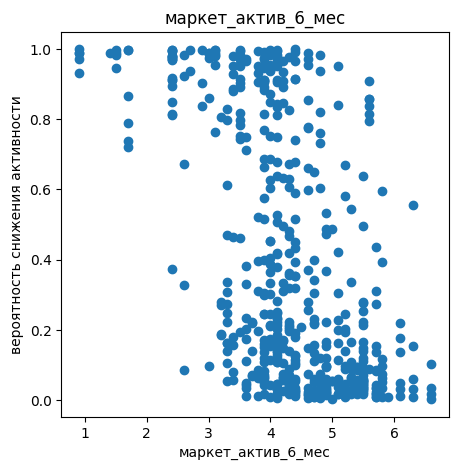

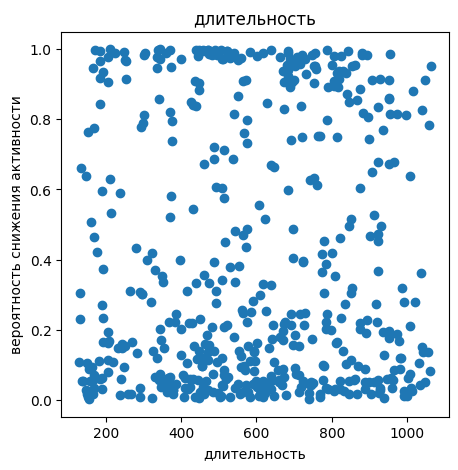

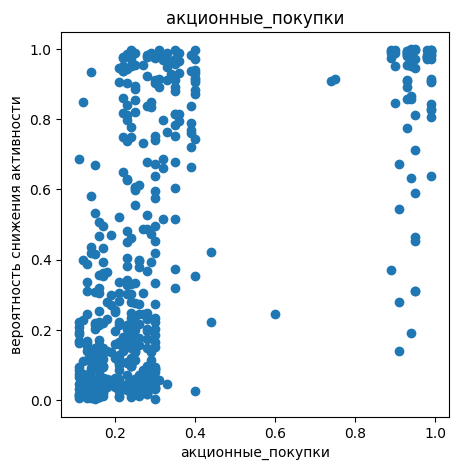

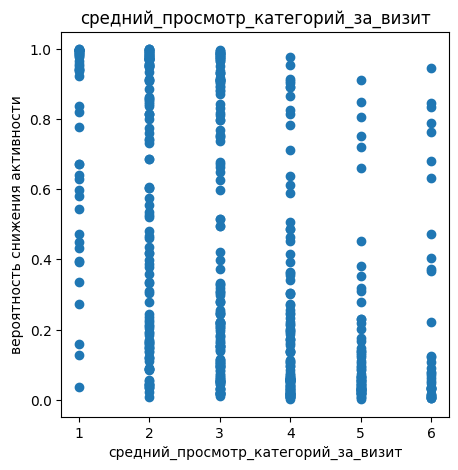

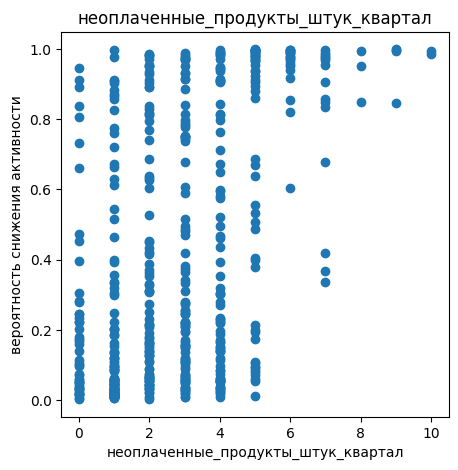

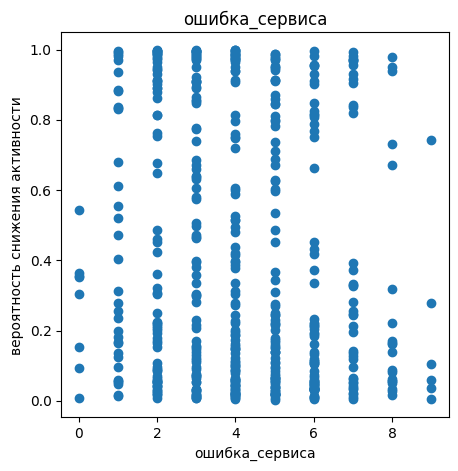

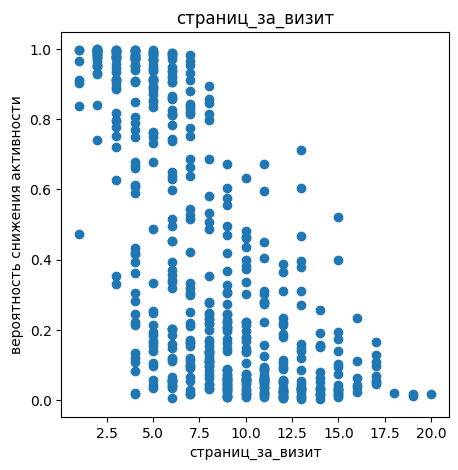

In [223]:
# Построим диаграммы рассеяния, демонстрирующие связь различных числовых значений с вероятностью снижения активности
for param in ['маркет_актив_6_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит',
       'время_предыдущий_месяц', 'время_текущий_месяц']:
    plt.figure(figsize=(5, 5))
    plt.scatter(df_segment[param],df_segment['вероятность_снижения'])
    # Добавляем заголовок и метки
    plt.title(param)
    plt.xlabel(param)
    plt.ylabel('вероятность снижения активности')
    # Отображаем график
    plt.show()

Приведенные распределения позволяют сделать следующие наблюдения:

- высокие показатели маркетинговой активности способствуют повышению покупательской активности - значит, увеличение числа рассылок может улучшить активность пользователей.
- длительность(время с момента регистрации на сайте) на первый взгляд не оказывает существенного влияния на активность.
- для пользователей с большим количеством акционных покупок велика вероятность снижения активности. Это может быть связано, например, с количеством проводимых акций.
- высокое количество просматриваемых категорий также снижает вероятность снижения активности.
- большое количество неоплаченных продуктов в корзине - признак снижения активности. 
- ошибки сервиса, п всей видимости, незначительно влияют на активность.
- число страниц, просматриваемых за визит, довольно неплохо коррелирует с вероятностью снижения активности - чем больше страниц просмотрит пользователь, тем ниже вероятность снижения его активности.
- в общем виде время, которое проводит пользователь на сайте, также влияет на активность - чем дольше пользователи просматривают сайт, тем ниже вероятность снижения их активности.

### Варианты увеличения покупательской активности различных групп

Выделим пользователей с высокой вероятностью снижения активности и высокими показателями выручки, проанализируем их признаки.

In [129]:
# Выделим пользователей, входящих в правый верхний угол предыдущей диаграммы
df_segment = df_segment.loc[(df_segment['прибыль'] > 3) & (df_segment['вероятность_снижения'] > 0.5)]

print('Число пользователей с высокими показателями прибыли и снижения активности: ',len(df_segment))

Число пользователей с высокими показателями прибыли и снижения активности:  159


In [130]:
df_segment.select_dtypes([np.number]).columns

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'время_предыдущий_месяц', 'время_текущий_месяц', 'вероятность_снижения',
       'прибыль'],
      dtype='object')

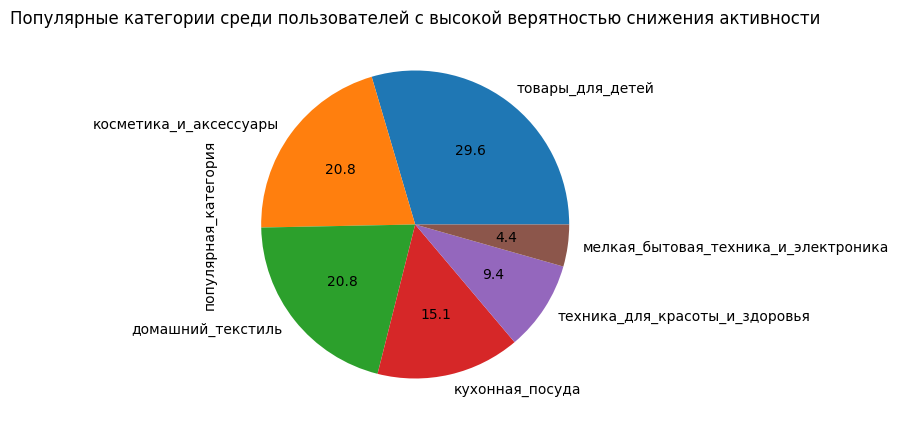

In [131]:
# Опредедим популярные категории товаров среди выделенных пользователей
df_segment['популярная_категория'].value_counts().plot(kind='pie', y= 'популярная_категория', figsize=(5,5), autopct='%.1f')
plt.title('Популярные категории среди пользователей с высокой верятностью снижения активности')
plt.show()

In [132]:
# Посчитаем, в какой категории пользователи потратили больше всего денег
segment_pivot = df_segment.pivot_table(index='популярная_категория', values='прибыль', aggfunc='sum')
segment_pivot.sort_values(by = 'прибыль', ascending=False)

,прибыль
популярная_категория,
товары_для_детей,202.49
косметика_и_аксессуары,150.19
домашний_текстиль,138.13
кухонная_посуда,99.72
техника_для_красоты_и_здоровья,65.42
мелкая_бытовая_техника_и_электроника,30.98


Товары для детей, домашний текстиль и косметика наиболее популярные среди пользователей категории - приносящие наибольшую прибыль магазину. Наименьшая прибыль в категории мелкая бытовая техника.

In [133]:
df_segment.columns

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'популярная_категория', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'время_предыдущий_месяц', 'время_текущий_месяц', 'вероятность_снижения',
       'прибыль'],
      dtype='object')

In [134]:
# Определим долю покупателей в каждой категории, которые пользуются скидками
segment_pivot['число_акционных_покупок'] = df_segment.loc[df_segment['акционные_покупки']>0.5].pivot_table(index='популярная_категория', values='прибыль', aggfunc='count')
segment_pivot['число_покупок'] = df_segment.pivot_table(index='популярная_категория', values='прибыль', aggfunc='count')
segment_pivot['доля_акционных_покупок'] = segment_pivot['число_акционных_покупок']/segment_pivot['число_покупок']
segment_pivot = segment_pivot.drop(['число_акционных_покупок','число_покупок'], axis=1)
segment_pivot['выручка_препредыдущий_месяц'] = df_segment.pivot_table(index='популярная_категория', values='выручка_препредыдущий_месяц', aggfunc='sum')
segment_pivot['выручка_предыдущий_месяц'] = df_segment.pivot_table(index='популярная_категория', values='выручка_предыдущий_месяц', aggfunc='sum')
segment_pivot['выручка_текущий_месяц'] = df_segment.pivot_table(index='популярная_категория', values='выручка_текущий_месяц', aggfunc='sum')

segment_pivot['время_предыдущий_месяц'] = df_segment.pivot_table(index='популярная_категория', values='время_предыдущий_месяц', aggfunc='median')
segment_pivot['время_текущий_месяц'] = df_segment.pivot_table(index='популярная_категория', values='время_текущий_месяц', aggfunc='median')
segment_pivot['разница_во_времени'] = segment_pivot['время_текущий_месяц'] - segment_pivot['время_предыдущий_месяц']

segment_pivot = segment_pivot.drop(['время_предыдущий_месяц','время_текущий_месяц'],axis=1)

segment_pivot['разница_выручки_месяц_назад'] = segment_pivot['выручка_предыдущий_месяц'] - segment_pivot['выручка_препредыдущий_месяц']
segment_pivot['разница_выручки_текущий_месяц'] = segment_pivot['выручка_текущий_месяц'] - segment_pivot['выручка_предыдущий_месяц']


segment_pivot.sort_values(by='прибыль', ascending=False)

,прибыль,доля_акционных_покупок,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,разница_во_времени,разница_выручки_месяц_назад,разница_выручки_текущий_месяц
популярная_категория,,,,,,,,
товары_для_детей,202.49,0.468085,218079.0,225252.5,238023.7,0.0,7173.5,12771.2
косметика_и_аксессуары,150.19,0.181818,155425.0,170742.5,183767.2,-1.0,15317.5,13024.7
домашний_текстиль,138.13,0.303030,153940.0,169250.5,179654.4,0.0,15310.5,10403.9
кухонная_посуда,99.72,0.375000,114280.0,130179.0,142102.6,0.5,15899.0,11923.6
техника_для_красоты_и_здоровья,65.42,0.466667,70162.0,68344.0,72010.0,1.0,-1818.0,3666.0
мелкая_бытовая_техника_и_электроника,30.98,0.142857,32161.0,39232.0,41449.8,0.0,7071.0,2217.8


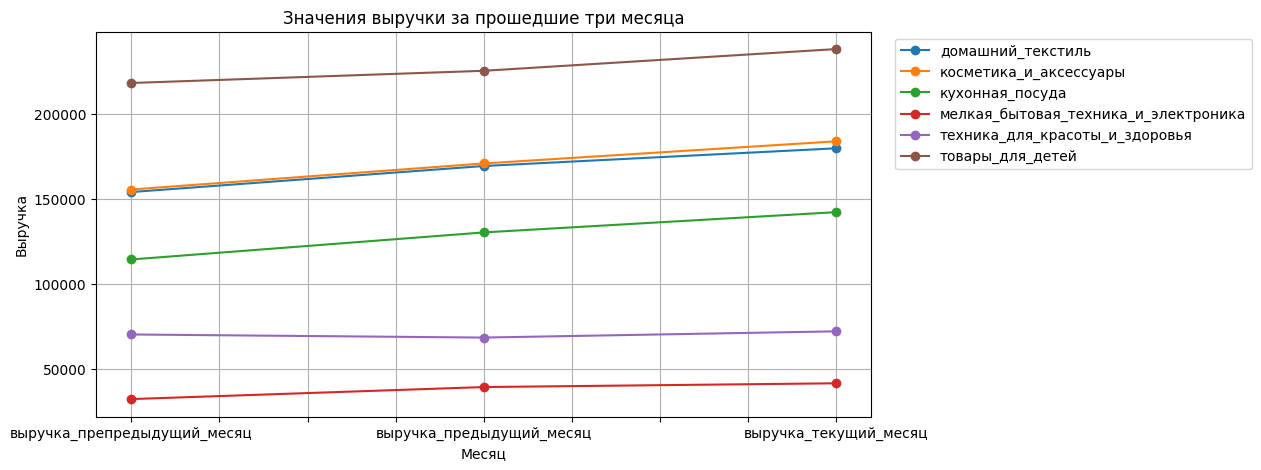

In [135]:
# Отобразим показатели выручки за последние три месяца
segment_pivot[['выручка_препредыдущий_месяц','выручка_предыдущий_месяц','выручка_текущий_месяц']].T.plot(style = 'o-', figsize=(10, 5), grid=True)
plt.title('Значения выручки за прошедшие три месяца')
plt.ylabel('Выручка')
plt.xlabel('Месяц')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show()

Для всех категорий, за исключением "техники для красоты и здоровья" в течение трех месяцев наблюдается стабильный рост общей выручки, а медианное значение времени, которое потратили на изучение сайта в прошлом и текущем месяцах остается практически неизменным.
 
Рассмотрим изменения в значениях выручке и предложим варианты для сохранения покупательской активности:

- товары_для_детей: Пользователи данной категории наиболее активно пользуются акционными предложениями. Показатели выручки в данной категории продолжают расти. Данный рост может быть связан с политикой компании - например, людям нравятся распродажи детских товаров и это способствует росту выручки. Однако, данный рост может быть связан и с сезонностью покупок, данные о которой мы в рамках текущих данных не располагаем. Для сохранения покупательской активности предлагается сохранить, и, возможно, расширить список акций на детские товары, включив в информационную рассылку пользователей дополнительные предложения из сопутствующих категорий - например, из категории "домашний_текстиль".

- домашний_текстиль: данная категория вторая по значению прибыльности, однако доля акционных покупок у пользователей здесь одна из самых низких. Категория демонстрирует снижение разницы в выручке. Для повышения активности покупателей, учитывая малый процент акционных покупок, предлагается увеличить число акций на товары данной категории.

- косметика_и_аксесуары: в данной категории самый низкая доля акционных покупок и также как и домашний текстиль, категория косметики демонстрирует некоторое снижение разницы в выручке. В качестве мотивации пользователей можно предложить увеличить число акционных предложений и включить в рекомендации товары из смежных категорий - например, из раздела "техника для красоты и здоровья".

- кухонная_посуда: пользователи данной категории довольно охотно совершают акционные покупки, однако и здесь наблюдается снижение разницы выручки. Кухонная посуда как правило имеет довольно длительный срок использования, поэтому для стимулирования покупателей можно предложить информационные рассылки с товарами из смежных категорий для дома - например, домашний текстиль и сохранить политику предложений акционных товаров.

- техника_для_красоты_и_здоровья: эта категория находится на втором месте по числу акционных покупок и демонстрирует рост разницы выручки. Как правило, техника имеет длительный срок эксплуатации и покупается либо по мере выхода из строя, либо - при проведении активной рекламной политики. В нашем случае предлагается сохранить политику проведения акций на товары данной категории и включить данный раздел в рекомендации к покупке при просмотре или покупках товаров других категорий, например, из раздела косметика и аксессуары.

- мелкая_бытовая_техника_и_электроника: данный раздел имеет самую низкую прибыльность и довольно низкую долю покупок по акциям, кроме того, демонстрирует существенное снижение разницы выручки. Учитывая, что техника имеет длительный срок эксплуатации, стимулировать активность пользователей данной категории можно либо расширением акционных предложений, либо - предложениями из соседних категорий. 

### Выводы по результатам анализа различных групп пользователей
   
Для дополнительного исследования были выбраны пользователи с высокой вероятностью снижения покупательской активности и при этом принесшие за прошедший период наибольшую выручку. Для данного сегмента пользователей был проведен анализ параметров пользователей с различными избранными категориями товаров.

В качестве основного приема предупреждения снижения покупательской активности можно выделить следующее:

Чем больше категорий просматривает пользователь и чем больше времени он проводит на сайте, тем ниже вероятность снижения его активности. Таким образом, для мотивации клиентов предлагается увеличить число маркетинговых коммуникаций с ними и внести модификации в структуру сайта таким образом, чтобы обеспечить большее удержание клиентов - например, предлагая им товары из смежных с интересующих их категориями.

В зависимости от предпочтений пользователей рекомендации по поддержанию активности могут несколько различаться - подробно они описаны в разделе 9.2. Суммируя, можно сделать следующие предложения:
- сохранить политику акций, попробовать расширить ее на категории с низким числом акционных покупок;
- для покупателей категорий товаров, имеющих длительное время эксплуатации увеличить число рассылок с предложениями товаров смежных категорий - например, для покупателей категории "техники для красоты и здоровья" - рекомендовать товары из раздела "косметика и аксессуары".

## Заключение

В процессе работы над проектом были исследованы данные о покупательской активности пользователей интернет-магазина, построена модель машинного обучения, позволяющая прогнозировать снижение покупательской активности пользователей, исследованы отдельные группы пользователей с высокой вероятностью снижения покупательской активности и даны рекомендации по поддержанию покупательской активности на прежнем уровне.

Работа выполнялась в следующем порядке действий:

- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Объединение таблиц
- Корреляционный анализ
- Использование пайплайнов
- Анализ важности признаков
- Сегментация покупателей

#### Загрузка данных

Для анализа использовались четыре датафрейма, содержащие информацию о коммуникациях с покупателем, его продуктовом поведении, выручке, времени, проводимом на сайте и данных о суммарной прибыли от пользователей. 
 
 
#### Предобработка данных
 
На этапе предобработки данных выполнено приведение стиля написания названий столбцов имеющихся таблиц и значений категориальных параметров к единому виду: заглавные буквы заменены на прописные, пробелы - на нижние подчеркивания, удалены опечатки, выполнен поиск пропущенных значений и дубликатов. Также id пользователей был установлен в качестве индекса в датафреймах.

#### Исследовательский анализ данных

В процессе исследовательского анализа данных рассматривались пользователи, совершавшие покупки в течение трех предыдущих месяцев. Анализ показал, что покупательская активность снизилась примерно у 40% пользователей.

Анализ распределений параметров, содержащих данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (df_market_file) проводился с учетом значения покупательской активности - сравнивались данные для пользователей с прежним уровнем активности и со снизившимся.

Данный подход позволил выявить следующие особенностей:

- Среди пользователей со снизившимся показателем активности доля клиентов, использующий премиум аккаунт больше, чем среди пользователей с прежним уровнем активности;
- В категориях товары для детей, косметика, текстиль и посуда существенное число пользователей снизили покупательскую активность. Менее всего снизилась активность пользователей в категориях техника для красоты и здоровья и мелкая бытовая техника.
- Для клиентов со снизившейся активностью характерен более низкий показатель маркетинговой активности за последние 6 месяцев. Возможно, для поддержания интереса пользователей необходимо увеличивать число коммуникаций с ними.
- К снижению активности более предрасположены клиенты, давно зарегестрированные на сайте.
- Снижение уровня покупательской активности наиболее часто наблюдается именно для покупателей, предпочитающий акционные покупки.
- Для снизившейся активности характерно и снижение числа просматриваемых категорий товаров.
- Число неоплаченных продуктов за квартал растет при низкой покупательской активности.
- Средние значения ошибок сервиса для покупателей с разными уровнями активности совпадают, нет оснований подозревать существенное влияние данного параметра на покупательскую активность.
- Пользователи со снизившейся покупательской активностью просматривают значительно меньше страниц на сайте.


Также в процессе анализа был обнаружен один пользователь с аномально высоким показателем выручки. Данный пользователь удален из датасетов как аномальный.


#### Объединение таблиц

Для удобства дальнейшей работы были объеденены таблицы df_market_file, df_market_money и df_market_time.

#### Корреляционный анализ

Для проведения корреляционного анализа была построена матрица коэффициентов корреляций для категориальных и количественных параметров сводной таблицы df_united, полученной в результате объединения данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении (df_market_file), данных о выручке, получаемой магазином с покупателя (df_market_money) и данных о времени (в минутах), которое покупатель провёл на сайте в течение периода (df_market_time). 

Анализ полученной матрицы позволил отметить отстутствие признаков мультиколлинеарности между элементами: наибольшее значение коэффициента корреляции составляет 0.84. Также были выделены признаки с наиболее заметными коэффициентами корреляции.



#### Использование пайплайнов

Целью создания модели машинного обучения было наиболее точное предсказание уровня активности пользователя.
Таким образом, решалась задача классификации, при которой лучшей считалась бы модель наилучшей точностью предсказаний. С учетом возможного дисбаланса целевого признака в качестве метрики была выбрана ROC-AUC.

С целью определения наиболее качественной модели машинного обучения был разработан пайплайн, включающий в себя этапы кодирования категориальных признаков, масштабирования числовых признаков, подготовки данных и обучения различных моделей машинного обучения.

Для кодирования категориальных признаков исполось OHE и ORD кодирование. Масштабирование количественных признаков осуществлялось с помощью инструментов StandardScaler() и MinMaxScaler().

В качестве моделей машинного обучения использовались:
- DecisionTreeClassifier с гиперпараметрами max_depth (количество уровней с правилами) в диапазоне от 2 до 5 и max_features (максимальное число признаков) в диапазоне от 2 до 17
- KNeighborsClassifier с гиперпараметром n_neighbors (число соседей) в диапазоне от 2 до 10
- LogisticRegression с L1-регуляризацией и значениями гиперпараметра C в диапазоне от 1 до 6
- SVC с гиперпараметрами StandardScaler() и MinMaxScaler().

По результатам работы наиболее качественный результат показала  модель логистической регрессии показала с показателем метрики на тренировочной выборке 0.89 и 0.86 на тестовой.


#### Анализ важности признаков

Для оценки значимости признаков использовался анализ SHAP-значений, который показал, наибольшее влияние на покупательскую активность оказывают акционные предложения, количество страниц и категорий, простматриваемых за визит, а также число неоплаченных товаров в корзине. Наименьшее влияние на активность имеет число рассылок в текущем месяце, ошибка сервиса и отказ от дополнительных предложений о товаре.

Низкое значение доли акционных покупок увеличивает вероятность снижения покупательской активности.
Также чем больше страниц за визит изучает пользователь и чем больше категорий он смотрит, тем меньше вероятность снижения покупательской активности.


#### Сегментация покупателей

Для дополнительного исследования были выбраны пользователи с высокой вероятностью снижения покупательской активности и при этом принесшие за прошедший период наибольшую выручку. Для данного сегмента пользователей был проведен анализ параметров пользователей с различными избранными категориями товаров.

В качестве основного приема предупреждения снижения покупательской активности можно выделить следующее:

Чем больше категорий просматривает пользователь и чем больше времени он проводит на сайте, тем ниже вероятность снижения его активности. Таким образом, для мотивации клиентов предлагается увеличить число маркетинговых коммуникаций с ними и внести модификации в структуру сайта таким образом, чтобы обеспечить большее удержание клиентов - например, предлагая им товары из смежных с интересующих их категориями.

В зависимости от предпочтений пользователей рекомендации по поддержанию активности могут несколько различаться - подробно они описаны в разделе 9.2. Суммируя, можно сделать следующие предложения:
- сохранить политику акций, попробовать расширить ее на категории с низким числом акционных покупок;
- для покупателей категорий товаров, имеющих длительное время эксплуатации увеличить число рассылок с предложениями товаров смежных категорий - например, для покупателей категории "техники для красоты и здоровья" - рекомендовать товары из раздела "косметика и аксессуары".